# Tutorial 2: Aprendizagem Não Supervisionada - Construção de um Sistema de Recomendação

Aluno: Ouhao Wu / Nº:123542 / Grupo: 9

---

Dataset: Steam Video Games (steam-200k.csv)

---

## Índice

* [1. Introdução](#1-introdução)
    * [1.1. Contexto do Dataset](#11-contexto-do-dataset)
    * [1.2. Objetivo do Tutorial](#12-objetivo-do-tutorial)
    * [1.3. Objetivo do Dataset e Análise Inicial das Features](#13-objetivo-do-dataset-e-análise-inicial-das-features)
* [2. Carregamento e Limpeza Inicial dos Dados](#2-carregamento-e-limpeza-inicial-dos-dados)
* [3. Análise Exploratória de Dados (EDA)](#3-análise-exploratória-de-dados-eda)
* [4. Transformação e Preparação dos Dados](#4-transformação-e-preparação-dos-dados)
* [5. Deteção de Outliers](#5-deteção-de-outliers)
    * [5.1. Padronização dos Dados](#51-padronização-dos-dados)
    * [5.2. Isolation Forest (IForest)](#52-isolation-forest-iforest)
    * [5.3. Análise de Componentes Principais (PCA) para Visualização](#53-análise-de-componentes-principais-pca-para-visualização)
    * [5.4. Visualização PCA dos Outliers IForest](#54-visualização-pca-dos-outliers-iforest)
    * [5.5. Análise com UMAP para Visualização](#55-análise-com-umap-para-visualização)
    * [5.6. Visualização UMAP dos Outliers IForest](#56-visualização-umap-dos-outliers-iforest)
    * [5.7. Local Outlier Factor (LOF)](#57-local-outlier-factor-lof)
    * [5.8. Visualização PCA dos Outliers LOF](#58-visualização-pca-dos-outliers-lof)
    * [5.9. Visualização UMAP dos Outliers LOF](#59-visualização-umap-dos-outliers-lof)
    * [5.10. Comparação: IForest vs. LOF](#510-comparação-iforest-vs-lof)
* [6. Redução de Dimensionalidade com PCA (para SOM/K-Means)](#6-redução-de-dimensionalidade-com-pca-para-somk-means)
    * [6.1. Análise de Variância Explicada](#61-análise-de-variância-explicada)
    * [6.2. Aplicação do PCA](#62-aplicação-do-pca)
* [7. Mapas Auto-Organizáveis (SOM)](#7-mapas-auto-organizáveis-som)
    * [7.1. SOM com Input Original (Padronizado)](#71-som-com-input-original-padronizado)
    * [7.2. SOM com Input Reduzido por PCA](#72-som-com-input-reduzido-por-pca)
    * [7.3. Comparação: SOM vs. PCA+SOM](#73-comparação-som-vs-pcasom)
* [8. Mineração de Regras de Associação (Apriori)](#8-mineração-de-regras-de-associação-apriori)
    * [8.1. Preparação dos Dados Transacionais](#81-preparação-dos-dados-transacionais)
    * [8.2. Aplicação do Apriori (Itemsets Frequentes)](#82-aplicação-do-apriori-itemsets-frequentes)
    * [8.3. Geração das Regras de Associação Iniciais](#83-geraçãio-das-regras-de-associação-iniciais)
    * [8.4. Análise das Regras Iniciais](#84-análise-das-regras-iniciais)
    * [8.5. Filtragem das Regras de Associação](#85-filtragem-das-regras-de-associação)
    * [8.6. Análise das Regras Filtradas](#86-análise-das-regras-filtradas)
    * [8.7. Exemplo Conceptual de Recomendação Apriori](#87-exemplo-conceptual-de-recomendação)
    * [8.8. Observação sobre Apriori](#88-observação-sobre-apriori)
* [9. Clustering com K-Means](#9-clustering-com-k-means)
    * [9.1. Encontrar o Número Ótimo de Clusters (k) - Método do Cotovelo](#91-encontrar-o-número-ótimo-de-clusters-k---método-do-cotovelo)
    * [9.2. Aplicar K-Means com o k Escolhido](#92-aplicar-k-means-com-o-k-escolhido)
    * [9.3. Visualizar os Clusters K-Means (usando UMAP)](#93-visualizar-os-clusters-k-means-usando-umap)
    * [9.4. Comparação: K-Means vs. SOM (PCA+SOM)](#94-comparação-k-means-vs-som-pcasom)
    * [9.5. Exemplo Conceptual de Recomendação K-mean](#95-exemplo-conceptual-de-recomendação)
* [10. Tabela Comparativa Final das Técnicas AANS Aplicadas](#10-tabela-comparativa-final-das-técnicas-aans-aplicadas)
* [11. Conclusão Geral](#11-conclusão-geral)


---

## 1. Introdução

Este *notebook* documenta a análise realizada no âmbito do **Tutorial 2** da cadeira de Aprendizagem Não Supervisionada. O foco principal é a aplicação de técnicas avançadas de AANS para explorar um dataset de interações de utilizadores e informar a construção de um **sistema de recomendação**.

### 1.1. Contexto do Dataset

O dataset utilizado neste tutorial é o **"Steam Video Games"** (`steam-200k.csv`), obtido do Kaggle. Ele contém aproximadamente 200.000 registos de interações de utilizadores com videojogos na popular plataforma de distribuição digital Steam.

As colunas principais do dataset são:
*   `user_id`: Identificador único para cada utilizador.
*   `game_title`: O nome do videojogo.
*   `behavior`: O tipo de interação registada. Inclui dois valores:
    *   `purchase`: Indica que o utilizador comprou (ou adicionou à biblioteca) o jogo.
    *   `play`: Indica que o utilizador jogou o jogo.
*   `value`: O valor associado ao comportamento.
    *   Se `behavior` for `purchase`, `value` é sempre 1.0.
    *   Se `behavior` for `play`, `value` representa o **número de horas** que o utilizador jogou esse jogo.

Este dataset representa um exemplo clássico de dados de **interação utilizador-item**, fundamentais para sistemas de recomendação colaborativos e baseados em conteúdo.



### 1.2. Objetivo do Tutorial

O objetivo principal deste tutorial, conforme definido no guião, é aplicar técnicas de aprendizagem não supervisionada para analisar os dados de interação e extrair insights que possam **refinar ou informar a lógica de um sistema de recomendação**. Especificamente, pretende-se:

1.  Realizar o pré-processamento e *data wrangling* necessários (usando Pandas) para preparar os dados para análise. 
2.  Implementar e comparar **duas técnicas de deteção de outliers** (neste caso, Isolation Forest e Local Outlier Factor) para identificar utilizadores ou interações anómalas e discutir o seu impacto potencial. 
3.  Aplicar **Mineração de Regras de Associação** (com Apriori) para descobrir relações entre os jogos comprados *E/OU* utilizar **Mapas Auto-Organizáveis (SOM)** para clustering e/ou redução de dimensionalidade/visualização. 
4.  **Comparar** a eficácia das abordagens utilizadas (outlier detection, SOM) com técnicas vistas anteriormente (como K-Means) ou outras alternativas (PCA vs. UMAP para visualização), focando na qualidade dos insights para a lógica de recomendação. 
5.  Realizar uma **análise comparativa aprofundada** do desempenho e dos insights obtidos pelas diferentes técnicas AANS aplicadas. 
6.  Documentar todo o processo, código, resultados e interpretações de forma clara e organizada neste Jupyter Notebook. 

### 1.3. Objetivo do Dataset e Análise Inicial das Features

O dataset Steam Video Games foi provavelmente compilado com o objetivo de facilitar a investigação e desenvolvimento de sistemas de recomendação para a plataforma Steam. A análise destes dados permite entender:
*   Quais jogos são mais populares (em compras e horas jogadas).
*   Que tipos de utilizadores existem (ex: casuais, hardcore, fãs de certos géneros).
*   Quais jogos são frequentemente comprados ou jogados em conjunto.

**Objetivo Implícito no Tutorial:** Utilizar AANS para descobrir estas estruturas (perfis de utilizador, relações entre jogos, anomalias) *sem* usar informação externa ou supervisão, de forma a que os padrões encontrados possam genuinamente informar um sistema de recomendação.

**Análise Inicial das Features e Dados:**
*   `user_id`, `game_title`: Identificadores/Categóricos. Essenciais para criar a matriz Utilizador-Item.
*   `behavior`: Categórica (nominal). Crucial para distinguir entre compra e jogo.
*   `value`: Numérica (contínua para 'play'). Apresenta **alta assimetria (skewness)** nas horas jogadas, exigindo atenção (ex: transformação logarítmica). O seu duplo significado (1 vs horas) precisa de ser tratado cuidadosamente.
*   **Dimensionalidade/Esparsidade:** Ao transformar para uma matriz Utilizador-Item (utilizadores x jogos), espera-se uma matriz de **alta dimensionalidade** (muitos jogos) e **muito esparsa** (cada utilizador interage apenas com uma pequena fração dos jogos totais). Isto tem implicações na escolha e desempenho dos algoritmos.
*   **Escala:** As horas jogadas (`value`) têm uma escala muito diferente de uma simples compra (valor 1). **Scaling/Padronização** será necessário antes de aplicar algoritmos sensíveis à distância/escala (PCA, SOM, K-Means, LOF).
*   **Valores Ausentes:** Não foram detetados valores ausentes explícitos (`NaN`) na análise inicial.

Portanto, neste tutorial,  irei aplicar as técnicas AANS mencionadas a este dataset, prestando especial atenção às suas características (esparsidade, dimensionalidade, escala, significado de 'value'), para extrair insights relevantes para a recomendação de jogos.

<a id="carregamento-exploracao"></a>
## 2. Carregamento e Exploração Inicial dos Dados

---

In [1]:
# Importar as bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import PCA
import umap 
from minisom import MiniSom
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import time

col_names = ['user_id', 'game_title', 'behavior', 'value', 'unused']

file_path = 'steam-200k.csv'

df = pd.read_csv(file_path, header=None, names=col_names, index_col=None)
print(f"Dataset carregado com sucesso!")
print(f"Dimensões iniciais: {df.shape[0]} linhas, {df.shape[1]} colunas")

print("\nPrimeiras 5 linhas do dataset:")
df.head(20)

Dataset carregado com sucesso!
Dimensões iniciais: 200000 linhas, 5 colunas

Primeiras 5 linhas do dataset:


,user_id,game_title,behavior,value,unused
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0,0
1,151603712,The Elder Scrolls V Skyrim,play,273.0,0
2,151603712,Fallout 4,purchase,1.0,0
3,151603712,Fallout 4,play,87.0,0
4,151603712,Spore,purchase,1.0,0
5,151603712,Spore,play,14.9,0
6,151603712,Fallout New Vegas,purchase,1.0,0
7,151603712,Fallout New Vegas,play,12.1,0
8,151603712,Left 4 Dead 2,purchase,1.0,0
9,151603712,Left 4 Dead 2,play,8.9,0


In [2]:
!pip install mlxtend
!pip install minisom

In [3]:
# Remover a coluna 'unused'
df = df.drop('unused', axis=1)
print("\nColuna 'unused' removida.")
print(f"Novas dimensões: {df.shape[0]} linhas, {df.shape[1]} colunas")
print("\nPrimeiras 5 linhas após limpeza inicial:")
df.head()


Coluna 'unused' removida.
Novas dimensões: 200000 linhas, 4 colunas

Primeiras 5 linhas após limpeza inicial:


,user_id,game_title,behavior,value
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0
1,151603712,The Elder Scrolls V Skyrim,play,273.0
2,151603712,Fallout 4,purchase,1.0
3,151603712,Fallout 4,play,87.0
4,151603712,Spore,purchase,1.0


In [4]:
print("\nInformações do DataFrame (Tipos de Dados e Nulos):")
print("----------------------------------------------------")
df.info()


Informações do DataFrame (Tipos de Dados e Nulos):
----------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     200000 non-null  int64  
 1   game_title  200000 non-null  object 
 2   behavior    200000 non-null  object 
 3   value       200000 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.1+ MB


In [5]:
print("\nContagem de valores nulos por coluna:")
df.isnull().sum()


Contagem de valores nulos por coluna:


user_id       0
game_title    0
behavior      0
value         0
dtype: int64

## 3. Análise Exploratória de Dados (EDA)

In [6]:
print("Contagem de comportamentos:")
print(df['behavior'].value_counts())
print("-" * 30) 

Contagem de comportamentos:
behavior
purchase    129511
play         70489
Name: count, dtype: int64
------------------------------


In [7]:
n_users = df['user_id'].nunique()
n_games = df['game_title'].nunique()
print(f"Número de utilizadores únicos: {n_users}")
print(f"Número de jogos únicos: {n_games}")
print("-" * 30) 

Número de utilizadores únicos: 12393
Número de jogos únicos: 5155
------------------------------


In [8]:
df_play = df[df["behavior"]=="play"].copy()

if not df_play.empty:
    print("Estatísticas descritivas das horas jogadas ('value' para 'play'):")
    print(df_play['value'].describe().apply(lambda x: f"{x:,.2f}"))
    
    # Verificar se existem valores de horas jogadas <= 0, o que seria estranho
    negative_or_zero_hours = df_play[df_play['value'] <= 0]['value'].count()
    if negative_or_zero_hours > 0:
        print(f"\nAtenção: Encontradas {negative_or_zero_hours} entradas com 0 ou menos horas jogadas.")
    else:
        print("\nTodas as entradas de 'play' têm valor > 0 horas.")
else:
    print("Não foram encontradas entradas de 'play' no dataset.")

Estatísticas descritivas das horas jogadas ('value' para 'play'):
count    70,489.00
mean         48.88
std         229.34
min           0.10
25%           1.00
50%           4.50
75%          19.10
max      11,754.00
Name: value, dtype: object

Todas as entradas de 'play' têm valor > 0 horas.


### Contagem de Comportamentos

Temos **129.511 registos de 'purchase'** (compra) e **70.489 de 'play'** (jogo), totalizando os **200.000 registos esperados**. É interessante notar que há quase o dobro de registos de compra em relação aos de jogo. Isso pode indicar que muitos jogos são comprados e não jogados, ou que o registo de 'play' representa o tempo total jogado por jogo, o que parece ser o caso, visto que há um campo com horas associadas.

---

### Entidades Únicas

O conjunto de dados inclui **12.393 utilizadores distintos** e **5.155 jogos distintos**. Isso fornece uma base sólida para construir a matriz utilizador-jogo, com aproximadamente **12.000 linhas e 5.000 colunas**.

---

### Estatísticas das Horas Jogadas

- **Média vs. Mediana**: A média de horas jogadas é **48,88 horas**, enquanto a mediana é de apenas **4,5 horas**. Essa discrepância confirma que a distribuição é **assimétrica à direita**, ou seja, a maioria dos utilizadores joga pouco, mas há alguns casos com número de horas extremamente elevado que puxam a média para cima.
  
- **Desvio Padrão**: O desvio padrão é **229,34**, muito superior à média, o que reforça a presença de **alta variabilidade** e **outliers potenciais**.

- **Valor Máximo**: O máximo observado foi de **11.754 horas**, o que equivale a mais de **16 meses jogando ininterruptamente (24/7)**. É um valor extremamente elevado, que pode indicar um **outlier** ou um utilizador altamente dedicado.

- **Valor Mínimo**: O valor mínimo é **0,1 horas** (6 minutos), o que é considerado razoável.

- **Qualidade dos Dados**: Não há registos com horas negativas ou zero, o que é um indicativo de **boa qualidade dos dados** no que se refere ao campo de tempo jogado.


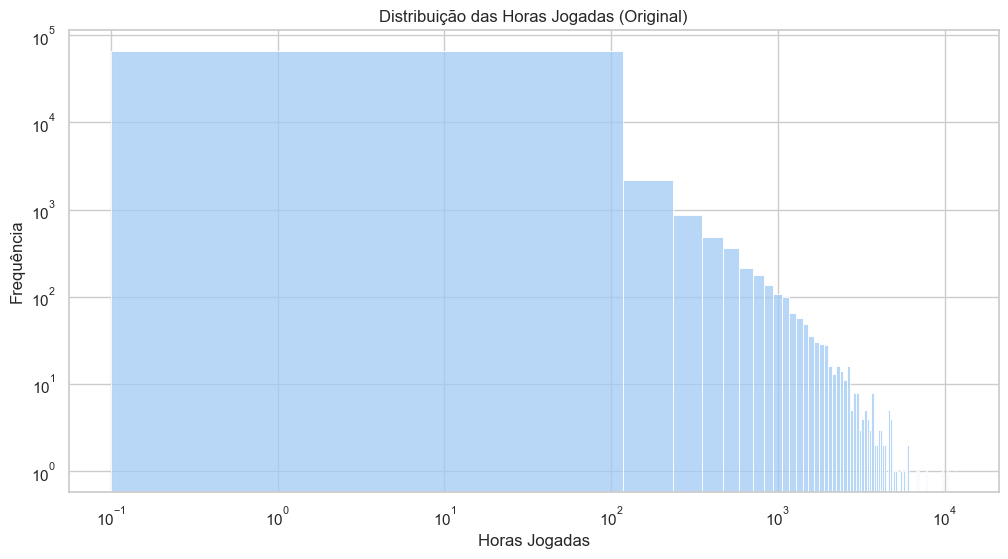

In [8]:
%matplotlib inline
sns.set(style="whitegrid")
sns.set_palette("pastel")

# Visualização da Distribuição das Horas Jogadas 
# Histograma 
plt.figure(figsize=(12, 6))
sns.histplot(df_play['value'], bins=100, kde=False) 
plt.title('Distribuição das Horas Jogadas (Original)')
plt.xlabel('Horas Jogadas')
plt.ylabel('Frequência')
plt.yscale('log') 
plt.xscale('log') 
plt.show()

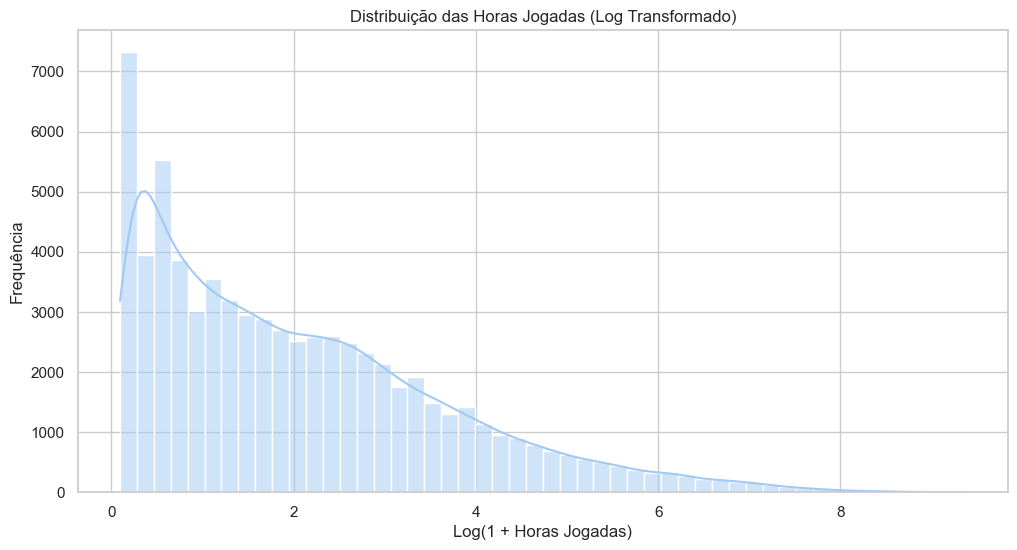

In [9]:
# Aplicar transformação logarítmica (log(1+x)
df_play['log_hours'] = np.log1p(df_play['value'])

# Histograma 
plt.figure(figsize=(12, 6))
sns.histplot(df_play['log_hours'], bins=50, kde=True) 
plt.title('Distribuição das Horas Jogadas (Log Transformado)')
plt.xlabel('Log(1 + Horas Jogadas)')
plt.ylabel('Frequência')
plt.show()

### Visualização das Horas Jogadas

#### Histograma Original 

Ao analisar o histograma original, mesmo com os eixos em escala logarítmica, eu observei uma concentração massiva de registos com poucas horas jogadas (entre 0.1 e aproximadamente 100 horas) e uma cauda longa à direita, com frequências residuais para valores muito elevados. Essa visualização confirma a assimetria severa já identificada nas estatísticas descritivas.

#### Histograma com Transformação Logarítmica 

Decidi aplicar a transformação `log(1 + horas)` com o objetivo de reduzir a assimetria da distribuição. O resultado foi bastante satisfatório: a nova distribuição tornou-se mais próxima de uma distribuição normal (ou log-normal), ainda que com alguma assimetria à direita. A maioria dos dados passou a concentrar-se entre 0 e aproximadamente 4 no eixo transformado, correspondendo a até 54 horas em termos absolutos. Essa transformação tornou os dados mais adequados para algoritmos sensíveis à escala e à distribuição, como SOM, K-Means e LOF .

---

In [10]:
# Jogos Mais Populares
# Por número de compras
top_purchased_games = df[df['behavior'] == 'purchase']['game_title'].value_counts().head(20)
print("Top 20 Jogos Mais Comprados:")
print(top_purchased_games)
print("-" * 30)

top_played_games_count = df_play['game_title'].value_counts().head(20)
print("Top 20 Jogos Mais Jogados (por nº de jogadores):")
print(top_played_games_count)
print("-" * 30)

top_played_games_hours = df_play.groupby('game_title')['value'].sum().sort_values(ascending=False).head(20)
print("Top 20 Jogos Mais Jogados (por total de horas):")
print(top_played_games_hours.apply(lambda x: f"{x:,.0f} horas"))

Top 20 Jogos Mais Comprados:
game_title
Dota 2                                          4841
Team Fortress 2                                 2323
Unturned                                        1563
Counter-Strike Global Offensive                 1412
Half-Life 2 Lost Coast                           981
Counter-Strike Source                            978
Left 4 Dead 2                                    951
Counter-Strike                                   856
Warframe                                         847
Half-Life 2 Deathmatch                           823
Garry's Mod                                      731
The Elder Scrolls V Skyrim                       717
Robocraft                                        689
Counter-Strike Condition Zero                    679
Counter-Strike Condition Zero Deleted Scenes     679
Heroes & Generals                                658
Half-Life 2                                      639
Sid Meier's Civilization V                       596
War Th

In [11]:
top_users_purchases = df[df['behavior'] == 'purchase']['user_id'].value_counts().head(15)
print("Top 15 Utilizadores (por nº de compras):")
print(top_users_purchases)
print("-" * 30)

top_users_games_played = df_play['user_id'].nunique() # Correção: Contar jogos únicos por user
top_users_games_played = df_play.groupby('user_id')['game_title'].nunique().sort_values(ascending=False).head(15)
print("Top 15 Utilizadores (por nº de jogos diferentes jogados):")
print(top_users_games_played)
print("-" * 30)

top_users_hours = df_play.groupby('user_id')['value'].sum().sort_values(ascending=False).head(15)
print("Top 15 Utilizadores (por total de horas jogadas):")
print(top_users_hours.apply(lambda x: f"{x:,.0f} horas"))

Top 15 Utilizadores (por nº de compras):
user_id
62990992    1075
33865373     783
30246419     766
58345543     667
76892907     597
20772968     595
11403772     592
64787956     591
22301321     568
47457723     557
33013552     520
53875128     505
86469479     480
49893565     477
11373749     458
Name: count, dtype: int64
------------------------------
Top 15 Utilizadores (por nº de jogos diferentes jogados):
user_id
62990992     498
11403772     314
138941587    299
47457723     298
49893565     297
24469287     284
48798067     254
36546868     235
51557405     210
17530772     209
116876958    208
22301321     207
11373749     204
975449       202
33013552     200
Name: game_title, dtype: int64
------------------------------
Top 15 Utilizadores (por total de horas jogadas):
user_id
73017395     11,754 horas
10599862     11,652 horas
100630947    10,853 horas
26762388     10,470 horas
153382649     9,640 horas
43684632      9,546 horas
48798067      9,427 horas
52731290      9,



### Análise de Popularidade: Jogos e Utilizadores

#### Jogos Mais Populares

Com base na contagem de compras, identifiquei que *"Dota 2"* e *"Team Fortress 2"* lideram a lista, o que era esperado devido ao seu modelo free-to-play. Outros títulos populares, como *"Unturned", "CS:GO", "Left 4 Dead 2"* e *"Counter-Strike Source"*, também aparecem com destaque, muitos deles frequentemente incluídos em bundles promocionais.

Ao observar o número de jogadores únicos, constatei que a lista dos jogos mais jogados se assemelha à dos mais comprados. Isso indica que os títulos amplamente adicionados às bibliotecas são também os mais experimentados pelos utilizadores.

No entanto, ao considerar o total de horas jogadas, notei uma mudança significativa: *"Dota 2"* destaca-se de forma expressiva, com quase 1 milhão de horas acumuladas no conjunto de dados. Títulos como "CS:GO" e "TF2" também apresentam um elevado tempo total de jogo. Além disso, surgem jogos como *"Sid Meier’s Civilization V"* e *"Football Manager"*, que, embora tenham menos jogadores únicos, demonstram elevado tempo médio de dedicação por utilizador. Isso revela jogos com alta rejogabilidade ou complexidade estratégica.

#### Utilizadores Mais Ativos

Ao analisar os utilizadores, percebi perfis distintos:

- O utilizador 62990992 destaca-se por possuir mais de 1.000 jogos adquiridos e por ter jogado um grande número de títulos distintos, o que sugere um perfil de colecionador ou explorador.

- Por outro lado, ao classificar os utilizadores segundo o total de horas jogadas, observei que os perfis são bastante diferentes. O utilizador 73017395, por exemplo, acumulou mais de 11.000 horas, embora não esteja entre os que compraram ou experimentaram mais jogos. Esse padrão é indicativo de perfis mais especializados, com foco intenso em poucos títulos.

---

### Reflexões e Próximos Passos

A transformação logarítmica (`log_hours`) revelou-se essencial para tornar os dados mais tratáveis e deverá ser empregada na construção da matriz utilizador-jogo.

Além disso, identifiquei que a popularidade extrema de alguns jogos, como *"Dota 2"* e *"CS:GO"*, poderá influenciar excessivamente as recomendações. Pretendo investigar estratégias de normalização ou métodos que incorporem medidas de novidade para mitigar esse efeito.

Por fim, a identificação de diferentes perfis de utilizador — colecionadores versus especialistas — abre caminho para abordagens de recomendação mais personalizadas. Pretendo explorar técnicas de clustering, como SOM, para segmentar esses grupos e avaliar recomendações direcionadas. A análise de regras de associação (Apriori) também será considerada como forma complementar de revelar padrões de co-compra relevantes para o sistema de recomendação.


# 4. Transformação e Preparação dos Dados
---

In [12]:
user_game_matrix = df_play.pivot_table(
        index='user_id',
        columns='game_title',
        values='log_hours', # Usar as horas transformadas
        fill_value=0 # Preencher jogos não jogados com 0
    )
print(f"Matriz Utilizador-Jogo criada com sucesso!")
print(f"Shape da matriz: {user_game_matrix.shape} (Utilizadores x Jogos)")
print("Exemplo das primeiras linhas/colunas da matriz:")
print(user_game_matrix.iloc[:5, :5]) # Mostrar um pequeno pedaço

sparsity = 1.0 - (np.count_nonzero(user_game_matrix) / float(user_game_matrix.size))
print(f"Esparsidade da matriz: {sparsity:.4f} ({sparsity*100:.2f}% de zeros)")



print("-" * 30)

print("A preparar os dados transacionais para Apriori...")
try:
    df_purchase = df[df['behavior'] == 'purchase']
    
    user_purchases_list = df_purchase.groupby('user_id')['game_title'].apply(list).tolist()

    print(f"Número de transações (utilizadores que compraram algo): {len(user_purchases_list)}")
    print("Exemplo das primeiras 5 transações (listas de jogos comprados):")
    for i, transaction in enumerate(user_purchases_list[:5]):
        print(f"  Utilizador {i+1}: {transaction[:10]}{'...' if len(transaction) > 10 else ''}")
except Exception as e:
    print(f"Ocorreu um erro ao preparar os dados para Apriori: {e}")

Matriz Utilizador-Jogo criada com sucesso!
Shape da matriz: (11350, 3600) (Utilizadores x Jogos)
Exemplo das primeiras linhas/colunas da matriz:
game_title  007 Legends  0RBITALIS  \
user_id                              
5250                0.0        0.0   
76767               0.0        0.0   
86540               0.0        0.0   
144736              0.0        0.0   
181212              0.0        0.0   

game_title  1... 2... 3... KICK IT! (Drop That Beat Like an Ugly Baby)  \
user_id                                                                  
5250                                                      0.0            
76767                                                     0.0            
86540                                                     0.0            
144736                                                    0.0            
181212                                                    0.0            

game_title  10 Second Ninja  10,000,000  
user_id                    



Os resultados obtidos confirmam que as transformações aplicadas foram bem-sucedidas e que os dados estão agora estruturados de forma adequada para as próximas etapas da análise.

#### Matriz Utilizador-Jogo (`user_game_matrix`)

Após filtrar apenas os utilizadores com registos de tempo de jogo e os jogos efetivamente jogados, obtive uma matriz com **11.350 utilizadores** e **3.600 jogos**. Estes valores são ligeiramente inferiores ao total de entidades únicas identificadas anteriormente (12.393 utilizadores e 5.155 jogos), o que era esperado, uma vez que nem todos os utilizadores chegaram a jogar e nem todos os jogos adquiridos foram jogados.

A esparsidade da matriz é de **99,83%**, o que representa um grau extremamente elevado de dispersão. Esta característica é comum neste tipo de dados e reforça o facto de que cada utilizador interage com apenas uma pequena fração do catálogo disponível. Diante disso, considero fundamental manter a **transformação logarítmica** das horas jogadas, bem como ter cautela na escolha de algoritmos que dependem de métricas de distância, pois podem ser significativamente afetados pela esparsidade.

#### Lista de Transações de Compra (`user_purchases_list`)

Construi também uma lista transacional para cada um dos **12.393 utilizadores**, contendo os jogos que cada um adquiriu. Esta estrutura encontra-se no formato adequado para a aplicação posterior do algoritmo **Apriori**, que requer dados em formato de transações (listas de itens por entidade).

---

# 5. Deteção de Outliers
---

## 5.1. Padronização dos Dados
---

In [13]:
matrix_to_scale = user_game_matrix.copy()
if 'outlier_if' in matrix_to_scale.columns:
    matrix_to_scale = matrix_to_scale.drop(['outlier_if'], axis=1)
if 'outlier_lof' in matrix_to_scale.columns:
    matrix_to_scale = matrix_to_scale.drop(['outlier_lof'], axis=1)

print(f"Input: Matriz Utilizador-Jogo original com shape {matrix_to_scale.shape}")

# Padronizar os dados
print("A padronizar a Matriz Utilizador-Jogo (StandardScaler)...")
start_time = time.time()
scaler = StandardScaler()
# Guardar nomes de linhas/colunas antes de escalar
user_ids_scaled = matrix_to_scale.index
game_titles_scaled = matrix_to_scale.columns
# Aplicar o scaler
X_scaled = scaler.fit_transform(matrix_to_scale)
end_time = time.time()
print(f"   Padronização concluída em {end_time - start_time:.2f} segundos.")
print(f"   Shape da matriz padronizada (X_scaled): {X_scaled.shape}")
print(f"   Tipo de X_scaled: {type(X_scaled)}") 

Input: Matriz Utilizador-Jogo original com shape (11350, 3600)
A padronizar a Matriz Utilizador-Jogo (StandardScaler)...
   Padronização concluída em 0.48 segundos.
   Shape da matriz padronizada (X_scaled): (11350, 3600)
   Tipo de X_scaled: <class 'numpy.ndarray'>


## 5.2. Isolation Forest (IForest)
---

In [14]:

print("A aplicar Isolation Forest aos dados padronizados...")
start_time = time.time()
iforest = IsolationForest(n_estimators=100,
                          contamination='auto', 
                          random_state=42,
                          n_jobs=-1)

# Treinar e prever nos dados padronizados X_scaled
outlier_preds_if = iforest.fit_predict(X_scaled)
end_time = time.time()
print(f"   Isolation Forest concluído em {end_time - start_time:.2f} segundos.")

# Analisar os resultados
n_outliers_if = (outlier_preds_if == -1).sum()
n_inliers_if = (outlier_preds_if == 1).sum()
total_if = len(outlier_preds_if)

print(f"\n   Resultados do Isolation Forest:")
print(f"     - Total de utilizadores analisados: {total_if}")
print(f"     - Número de outliers identificados (-1): {n_outliers_if}")
print(f"     - Número de inliers identificados (1): {n_inliers_if}")
print(f"     - Proporção de outliers: {n_outliers_if / total_if:.4f} ({ (n_outliers_if / total_if * 100):.2f}%)")

user_game_matrix['outlier_if'] = pd.Series(outlier_preds_if, index=user_ids_scaled)

A aplicar Isolation Forest aos dados padronizados...
   Isolation Forest concluído em 0.36 segundos.

   Resultados do Isolation Forest:
     - Total de utilizadores analisados: 11350
     - Número de outliers identificados (-1): 20
     - Número de inliers identificados (1): 11330
     - Proporção de outliers: 0.0018 (0.18%)


## 5.3. Análise de Componentes Principais (PCA) para Visualização
---

In [15]:
print("A aplicar PCA (2 componentes)...")
start_time = time.time()
pca = PCA(n_components=2, random_state=42)
X_pca_viz = pca.fit_transform(X_scaled)
pca_time = time.time() - start_time
print(f"   PCA concluído em {pca_time:.2f} segundos.")
print(f"   Shape após PCA: {X_pca_viz.shape}")


explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = explained_variance_ratio.cumsum()

print(f"\n   Variância explicada pelo Componente Principal 1: {explained_variance_ratio[0]:.4f} ({explained_variance_ratio[0]*100:.2f}%)")
print(f"   Variância explicada pelo Componente Principal 2: {explained_variance_ratio[1]:.4f} ({explained_variance_ratio[1]*100:.2f}%)")
print(f"   Variância Acumulada pelos 2 Componentes: {cumulative_variance[1]:.4f} ({cumulative_variance[1]*100:.2f}%)")

print("\nPasso 5.3 concluído. Componentes PCA ('X_pca_viz') e variância estão prontos.")

A aplicar PCA (2 componentes)...
   PCA concluído em 0.64 segundos.
   Shape após PCA: (11350, 2)

   Variância explicada pelo Componente Principal 1: 0.0437 (4.37%)
   Variância explicada pelo Componente Principal 2: 0.0269 (2.69%)
   Variância Acumulada pelos 2 Componentes: 0.0706 (7.06%)

Passo 5.3 concluído. Componentes PCA ('X_pca_viz') e variância estão prontos.


## 5.4. Visualização PCA dos Outliers IForest
---

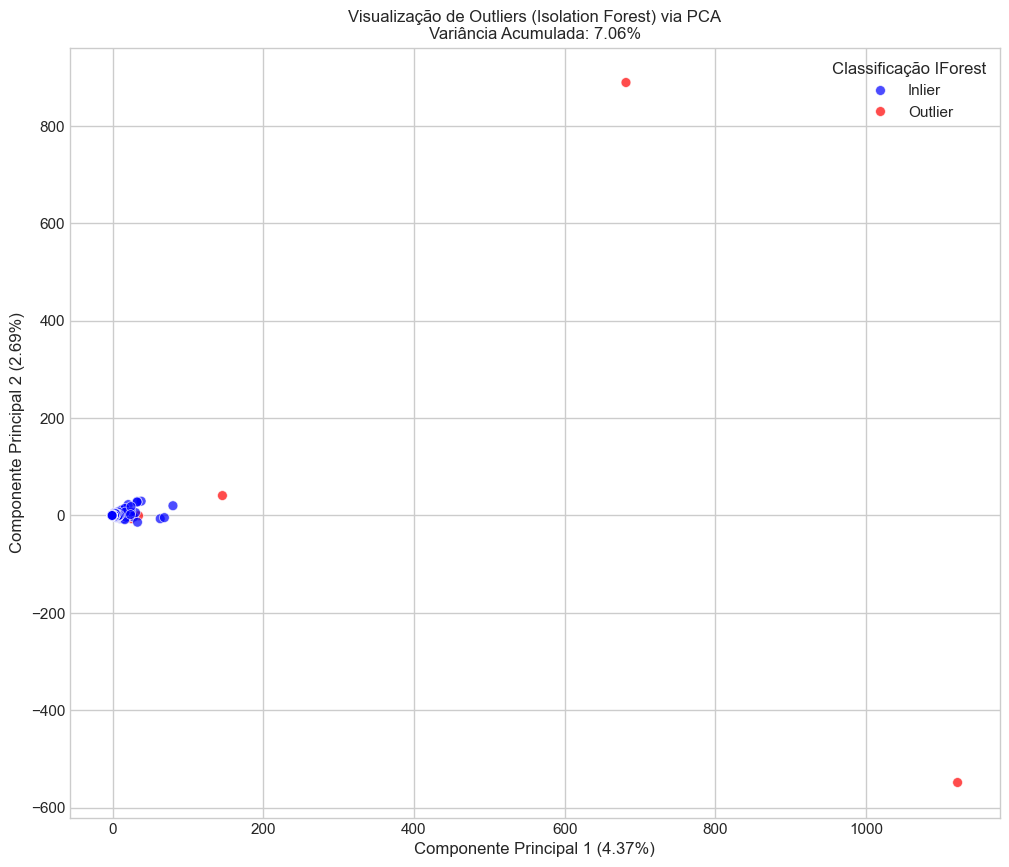

In [16]:
# Criar DataFrame para visualização
df_viz_pca_if = pd.DataFrame({
    'user_id': user_ids_scaled,
    'PCA1': X_pca_viz[:, 0],
    'PCA2': X_pca_viz[:, 1],
    'Outlier (IForest)': pd.Series(outlier_preds_if, index=user_ids_scaled).map({1: 'Inlier', -1: 'Outlier'})
})

# Gerar o Gráfico PCA
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 10))
sns.scatterplot(data=df_viz_pca_if, x='PCA1', y='PCA2', hue='Outlier (IForest)',
                palette={'Inlier': 'blue', 'Outlier': 'red'}, alpha=0.7, s=50)

plt.title(f'Visualização de Outliers (Isolation Forest) via PCA\nVariância Acumulada: {cumulative_variance[1]*100:.2f}%')
plt.xlabel(f'Componente Principal 1 ({explained_variance_ratio[0]*100:.2f}%)')
plt.ylabel(f'Componente Principal 2 ({explained_variance_ratio[1]*100:.2f}%)')
plt.legend(title='Classificação IForest')
plt.grid(True)
plt.show()

Variância Explicada: Este é um resultado muito importante. Os dois primeiros componentes principais explicam apenas 7.06% da variância total dos dados (4.37% + 2.69%). Isto é muito baixo e significa que a visualização 2D do PCA é uma representação altamente simplificada da estrutura real dos dados, que vive em 3600 dimensões. Devemos ter muito cuidado ao tirar conclusões apenas do gráfico PCA.

Apesar da baixa variância explicada, o gráfico PCA consegue mostrar uma separação visual.
A grande maioria dos inliers (azul) está aglomerada muito perto da origem.
Os outliers (vermelho) aparecem claramente afastados deste aglomerado principal, muitas vezes em posições extremas nos eixos. Isto confirma visualmente que os pontos identificados pelo IForest são, de facto, muito diferentes da média nesse espaço reduzido pelas componentes principais.

## 5.5. Análise com UMAP para Visualização
---

In [17]:
print("A aplicar UMAP (2 componentes)... (Pode demorar um pouco)")
start_time = time.time()
reducer = umap.UMAP(n_components=2,
                    n_neighbors=15, 
                    min_dist=0.1,  
                    random_state=42,
                    n_jobs=-1) 
X_umap_viz = reducer.fit_transform(X_scaled) 
umap_time = time.time() - start_time
print(f"   UMAP concluído em {umap_time:.2f} segundos.")
print(f"   Shape após UMAP: {X_umap_viz.shape}")

A aplicar UMAP (2 componentes)... (Pode demorar um pouco)


D:\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


   UMAP concluído em 34.63 segundos.
   Shape após UMAP: (11350, 2)


## 5.6. Visualização UMAP dos Outliers IForest
---

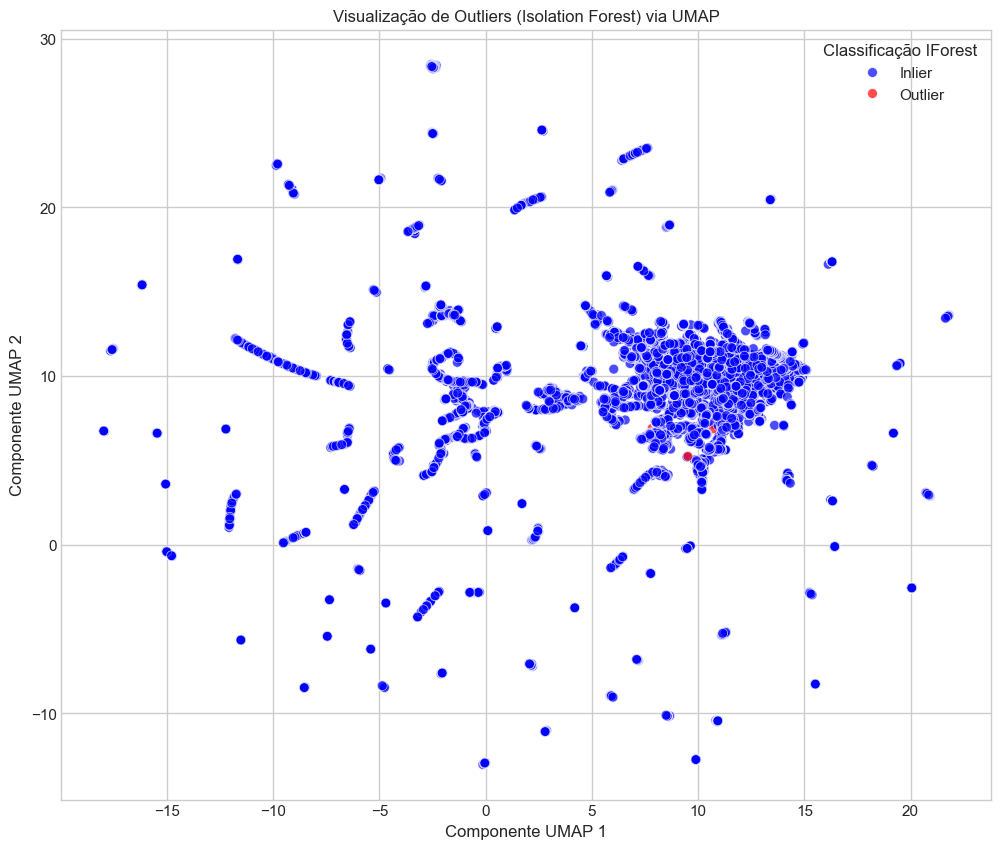

In [18]:
df_viz_umap_if = pd.DataFrame({
    'user_id': user_ids_scaled,
    'UMAP1': X_umap_viz[:, 0],
    'UMAP2': X_umap_viz[:, 1],
    'Outlier (IForest)': pd.Series(outlier_preds_if, index=user_ids_scaled).map({1: 'Inlier', -1: 'Outlier'})
})

# Gerar o Gráfico UMAP
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 10))
sns.scatterplot(data=df_viz_umap_if, x='UMAP1', y='UMAP2', hue='Outlier (IForest)',
                palette={'Inlier': 'blue', 'Outlier': 'red'}, alpha=0.7, s=50)
plt.title('Visualização de Outliers (Isolation Forest) via UMAP')
plt.xlabel('Componente UMAP 1')
plt.ylabel('Componente UMAP 2')
plt.legend(title='Classificação IForest')
plt.grid(True)
plt.show()


#### Padronização (StandardScaler)

Apliquei a padronização à matriz `user_game_matrix`, que contém as horas de jogo transformadas em logaritmo. Utilizei o `StandardScaler`, e o resultado foi a matriz `X_scaled` com dimensões **11.350 x 3.600**, onde cada coluna (jogo) passou a ter média 0 e desvio padrão 1. Este pré-processamento é fundamental para garantir que jogos com escalas muito distintas sejam comparáveis em algoritmos sensíveis à escala, tais como **PCA, LOF, SOM e K-Means**.

#### Deteção de Outliers (Isolation Forest)

Em seguida, apliquei o algoritmo **Isolation Forest** aos dados padronizados (`X_scaled`). Utilizando `contamination='auto'`, o modelo identificou **20 utilizadores** (aproximadamente **0,18%**) como outliers. Este número reduzido sugere que o modelo está a isolar apenas os perfis mais extremos e atípicos do conjunto, possivelmente utilizadores com comportamentos invulgares quanto ao volume ou à diversidade dos jogos jogados.

#### Análise de Componentes Principais (PCA)

A análise PCA revelou que os dois primeiros componentes principais capturam apenas **7,06% da variância total** dos dados (sendo **4,37%** para o primeiro componente e **2,69%** para o segundo). Essa percentagem é muito baixa, o que indica que uma projeção bidimensional via PCA **não representa adequadamente** a complexidade dos dados originais. Assim, considerei que qualquer visualização baseada em PCA deverá ser interpretada com **cautela**.

#### Visualização PCA 

Apesar da baixa variância explicada, a visualização PCA gerada permitiu observar uma **separação clara dos outliers**. Os 20 outliers identificados (representados a vermelho) surgem visualmente afastados do aglomerado central dos utilizadores normais (a azul), que se concentra próximo da origem. Essa visualização, mesmo simplificada, corrobora a **distinção estrutural** destes perfis.

#### Redução e Visualização UMAP 

Decidi aplicar também o **UMAP** para redução dimensional e visualização. O processo demorou cerca de 35 segundos e resultou numa visualização bidimensional (`input_file_1.png`) que revela **estruturas complexas e não-lineares**. Foi possível identificar um núcleo denso principal, com ramificações e aglomerados secundários. Os 20 outliers continuam visivelmente distintos, situando-se em regiões periféricas ou afastadas das concentrações principais, o que reforça a sua **anomalia** em termos de estrutura local e vizinhança.

---

Concluo que os dados foram **adequadamente preparados** com a padronização e que o **Isolation Forest** foi eficaz em identificar um pequeno grupo de outliers globais consistentes. As visualizações com **PCA** e **UMAP**, apesar de apresentarem níveis de representação distintos (com limitações no PCA devido à baixa variância), **confirmaram visualmente** a posição periférica e distinta destes utilizadores em relação à maioria. As matrizes resultantes — `X_scaled`, `X_pca_viz` e `X_umap_viz` — estão agora prontas para serem utilizadas nas próximas etapas do projeto.


## 5.7. Local Outlier Factor (LOF)

---

In [19]:
print("A aplicar Local Outlier Factor (LOF)...")
start_time = time.time()
lof = LocalOutlierFactor(n_neighbors=20, 
                         contamination='auto',
                         novelty=False,
                         n_jobs=-1)

# fit_predict nos dados padronizados X_scaled
outlier_preds_lof = lof.fit_predict(X_scaled)
end_time = time.time()
print(f"   LOF concluído em {end_time - start_time:.2f} segundos.")

# Analisar os resultados
n_outliers_lof = (outlier_preds_lof == -1).sum()
n_inliers_lof = (outlier_preds_lof == 1).sum()
total_lof = len(outlier_preds_lof)

print(f"\n   Resultados do Local Outlier Factor (LOF):")
print(f"     - Total de utilizadores analisados: {total_lof}")
print(f"     - Número de outliers identificados (-1): {n_outliers_lof}")
print(f"     - Número de inliers identificados (1): {n_inliers_lof}")
print(f"     - Proporção de outliers: {n_outliers_lof / total_lof:.4f} ({ (n_outliers_lof / total_lof * 100):.2f}%)")

user_game_matrix['outlier_lof'] = pd.Series(outlier_preds_lof, index=user_ids_scaled)
print("\n   Comparação entre IForest e LOF:")
both_outliers = user_game_matrix[(user_game_matrix['outlier_if'] == -1) & (user_game_matrix['outlier_lof'] == -1)].shape[0]
only_if_outliers = user_game_matrix[(user_game_matrix['outlier_if'] == -1) & (user_game_matrix['outlier_lof'] == 1)].shape[0]
only_lof_outliers = user_game_matrix[(user_game_matrix['outlier_if'] == 1) & (user_game_matrix['outlier_lof'] == -1)].shape[0]

print(f"     - Outliers identificados por AMBOS: {both_outliers}")
print(f"     - Outliers identificados APENAS pelo IForest: {only_if_outliers}")
print(f"     - Outliers identificados APENAS pelo LOF: {only_lof_outliers}")

A aplicar Local Outlier Factor (LOF)...
   LOF concluído em 3.43 segundos.

   Resultados do Local Outlier Factor (LOF):
     - Total de utilizadores analisados: 11350
     - Número de outliers identificados (-1): 6080
     - Número de inliers identificados (1): 5270
     - Proporção de outliers: 0.5357 (53.57%)

   Comparação entre IForest e LOF:
     - Outliers identificados por AMBOS: 20
     - Outliers identificados APENAS pelo IForest: 0
     - Outliers identificados APENAS pelo LOF: 6060


## 5.8. Visualização PCA dos Outliers LOF
---

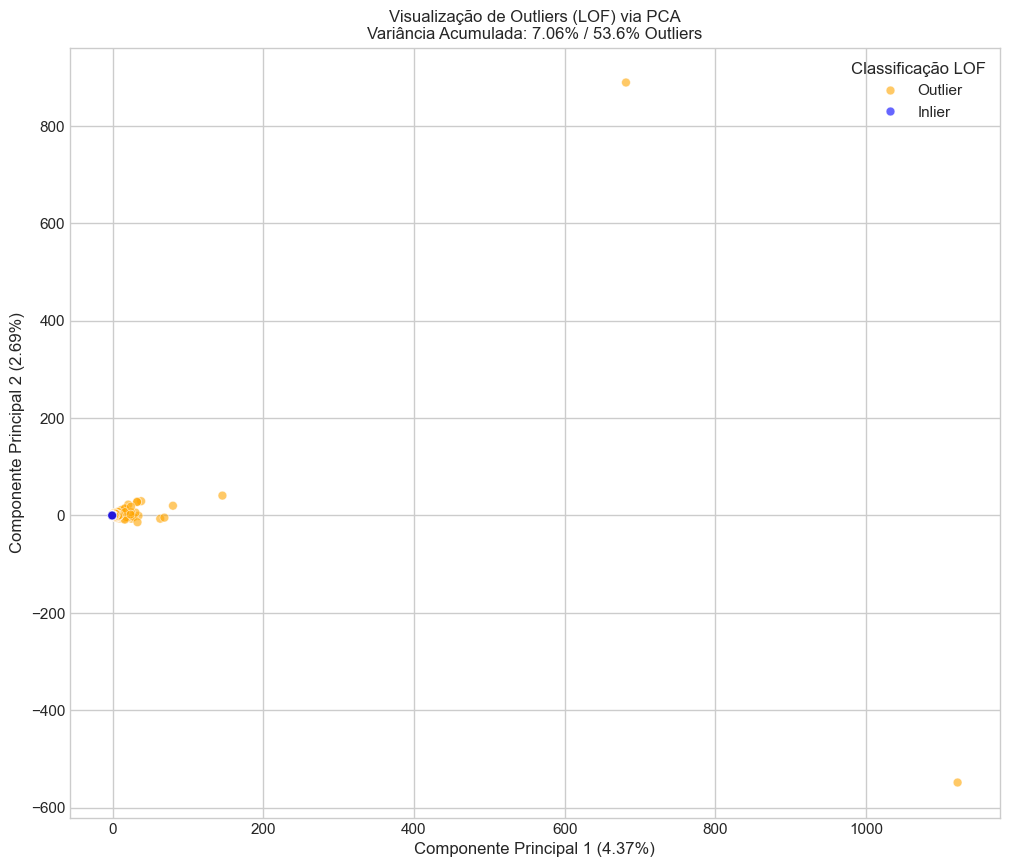

In [20]:
df_viz_pca_lof = pd.DataFrame({
    'user_id': user_ids_scaled,
    'PCA1': X_pca_viz[:, 0],
    'PCA2': X_pca_viz[:, 1],
    'Outlier (LOF)': pd.Series(outlier_preds_lof, index=user_ids_scaled).map({1: 'Inlier', -1: 'Outlier'})
})

# Gerar o Gráfico PCA
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 10))
sns.scatterplot(data=df_viz_pca_lof, x='PCA1', y='PCA2', hue='Outlier (LOF)',
                palette={'Inlier': 'blue', 'Outlier': 'orange'},
                alpha=0.6, s=40) 
plt.title(f'Visualização de Outliers (LOF) via PCA\nVariância Acumulada: {cumulative_variance[1]*100:.2f}% / {(n_outliers_lof / total_lof * 100):.1f}% Outliers')
plt.xlabel(f'Componente Principal 1 ({explained_variance_ratio[0]*100:.2f}%)')
plt.ylabel(f'Componente Principal 2 ({explained_variance_ratio[1]*100:.2f}%)')
plt.legend(title='Classificação LOF')
plt.grid(True)
plt.show()

## 5.9. Visualização UMAP dos Outliers LOF
---

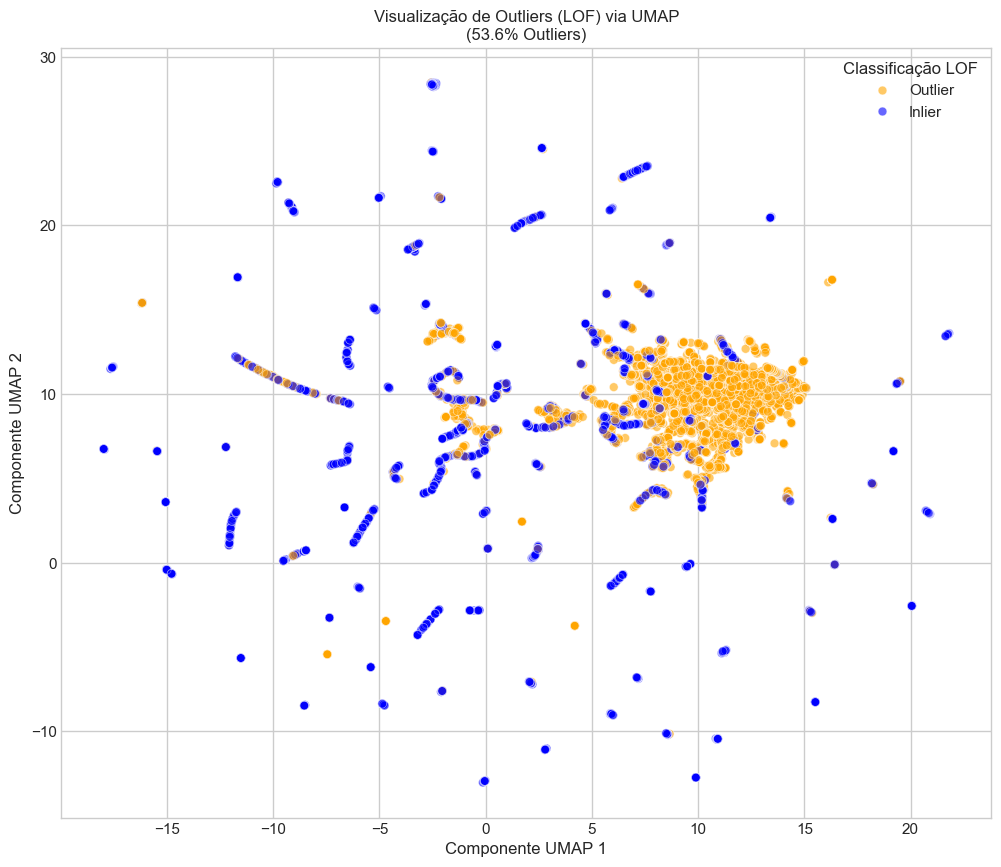

In [21]:
df_viz_umap_lof = pd.DataFrame({
    'user_id': user_ids_scaled,
    'UMAP1': X_umap_viz[:, 0],
    'UMAP2': X_umap_viz[:, 1],
    'Outlier (LOF)': pd.Series(outlier_preds_lof, index=user_ids_scaled).map({1: 'Inlier', -1: 'Outlier'})
})

# Gerar o Gráfico UMAP
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 10))
sns.scatterplot(data=df_viz_umap_lof, x='UMAP1', y='UMAP2', hue='Outlier (LOF)',
                palette={'Inlier': 'blue', 'Outlier': 'orange'},
                alpha=0.6, s=40)
plt.title(f'Visualização de Outliers (LOF) via UMAP\n({(n_outliers_lof / total_lof * 100):.1f}% Outliers)')
plt.xlabel('Componente UMAP 1')
plt.ylabel('Componente UMAP 2')
plt.legend(title='Classificação LOF')
plt.grid(True)
plt.show()

---
#### Aplicação do LOF (LocalOutlierFactor)

Apliquei o algoritmo **Local Outlier Factor (LOF)** à matriz padronizada `X_scaled`, gerada no Passo 5.1. O objetivo foi identificar outliers com base na densidade local em relação aos seus vizinhos mais próximos. A execução do modelo foi eficiente, com um tempo de processamento aproximado de **3,5 segundos**.

---
#### Resultados Numéricos

Utilizando `contamination='auto'`, o LOF classificou **6.080 utilizadores (53,6%)** como outliers. Este valor é surpreendentemente elevado, mas consistente com uma execução anterior realizada antes da padronização explícita. A elevada proporção sugere que o LOF está a captar variações locais significativas no comportamento dos utilizadores.

A comparação com os resultados do Isolation Forest confirmou que **todos os 20 outliers globais identificados anteriormente também foram detectados pelo LOF**. No entanto, o LOF assinalou **6.060 outliers adicionais**, que refletem desvios mais sutis em relação à densidade local.

---
#### Visualização PCA 

Utilizei a **projeção PCA** (com os dois primeiros componentes que explicam apenas 7,06% da variância) para visualizar os resultados do LOF. A análise permitiu as seguintes observações:

- Os **pontos mais distantes da origem**, que também haviam sido identificados como outliers pelo Isolation Forest, foram corretamente classificados como **outliers (em laranja)** pelo LOF.
- Contudo, devido à elevada quantidade de outliers LOF, a **região central do gráfico apresenta uma mistura intensa** de inliers (azul) e outliers (laranja), dificultando a distinção clara entre os dois grupos nesta representação bidimensional de baixa variância.

---
#### Visualização UMAP 

A visualização com **UMAP** revelou-se muito mais informativa quanto ao comportamento do LOF. Foi possível observar:

- Os **inliers (azul)** concentram-se nas regiões **mais densas e coesas**, como o núcleo central e filamentos estruturais.
- Os **outliers (laranja)** tendem a ocupar áreas **menos densas**, aparecendo nas **margens dos aglomerados**, entre estruturas, ou isolados na periferia. Existe também uma presença notável de outliers na zona central, muitas vezes **em torno dos núcleos densos**, atuando como pontos de transição ou ligação entre diferentes regiões do espaço.

Esta distribuição espacial reforça a interpretação de que o LOF **identifica outliers com base em desvios da densidade local**, e não apenas por distância global, como o Isolation Forest. 


---
## 5.10. Comparação Formal entre Isolation Forest e LOF

Nesta secção, eu apresento uma comparação direta entre os algoritmos **Isolation Forest (IForest)** e **Local Outlier Factor (LOF)**, ambos aplicados à matriz padronizada `X_scaled`, representando os perfis de jogo dos utilizadores. A análise tem por base os resultados obtidos .

---

####  Resultados

**Isolation Forest :**

- Identificou **20 outliers** (0,18% do total de utilizadores).
- Detectou **anomalias globais**, isolando perfis de utilizador que exigem menos partições para separação na estrutura da floresta aleatória.
- Esses utilizadores apresentam **comportamentos globalmente extremos**, quer em volume de horas, quer em variedade de jogos.
- As visualizações PCA e UMAP confirmaram que estes pontos se encontram **bem afastados das regiões densas** de utilizadores normais.

**Local Outlier Factor :**

- Identificou **6.080 outliers** (53,6%) com `contamination='auto'`.
- Baseia-se em **densidade local**, comparando a vizinhança de cada ponto com a média de densidade dos seus vizinhos.
- O número elevado de outliers reflete a **alta dimensionalidade (3600)** e **esparsidade (99,83%)** do dataset.
- A visualização UMAP revelou que esses outliers se localizam **nas franjas, entre clusters densos ou em regiões isoladas**.

---

####  Tabela de Comparação: IForest vs. LOF

| Característica                      | Isolation Forest                      | Local Outlier Factor (LOF)                          |
|------------------------------------|----------------------------------------|----------------------------------------------------|
| **Princípio**                      | Isolamento por partições aleatórias    | Comparação de densidade local com vizinhança       |
| **Tipo de Outlier**                | Global                                 | Local                                               |
| **Sensibilidade a:**              | Extremos globais, isolamento geral     | Densidade local, esparsidade, dimensionalidade     |
| **Nº de Outliers (`auto`)**        | 20 (0,18%)                             | 6.080 (53,6%)                                       |
| **Sobreposição**                   | Todos os 20 estão no LOF               | 6.060 não estão no IForest                         |
| **Interpretação Provável**         | Perfis extremamente atípicos           | Perfis localmente incomuns                         |
| **Praticidade para Remoção**       | Viável (impacto reduzido)              | Impraticável (número muito elevado)                |
| **Tempo de Execução**              | Muito rápido (~0,4s)                   | Moderado (~3,5–18s dependendo da execução)         |
| **Impacto da Padronização**        | Baixo                                   | Alto (número de outliers aumentou após padronizar) |

---


#### Conclusão da Comparação

Ambos os métodos são valiosos, mas têm finalidades diferentes:
- O **Isolation Forest** é mais eficaz na **identificação de outliers globais**, práticos de tratar e com maior impacto potencial sobre os modelos subsequentes.
- O **LOF** evidencia a **complexidade da densidade local**, funcionando mais como uma ferramenta de **diagnóstico metodológico** que alerta para a diversidade e dispersão dos perfis de utilizador no espaço de features.


---
# 6. Redução de Dimensionalidade com PCA (para SOM/K-Means)
---

## 6.1. Análise de Variância Explicada

Input: Matriz padronizada 'X_scaled' com shape (11350, 3600)

A aplicar PCA para as primeiras 500 componentes...
   Análise PCA concluída em 2.74 segundos.

Número de componentes para explicar aproximadamente:
   - 80% da variância: > 500 (não atingido)
   - 90% da variância: > 500 (não atingido)
   - 95% da variância: > 500 (não atingido)


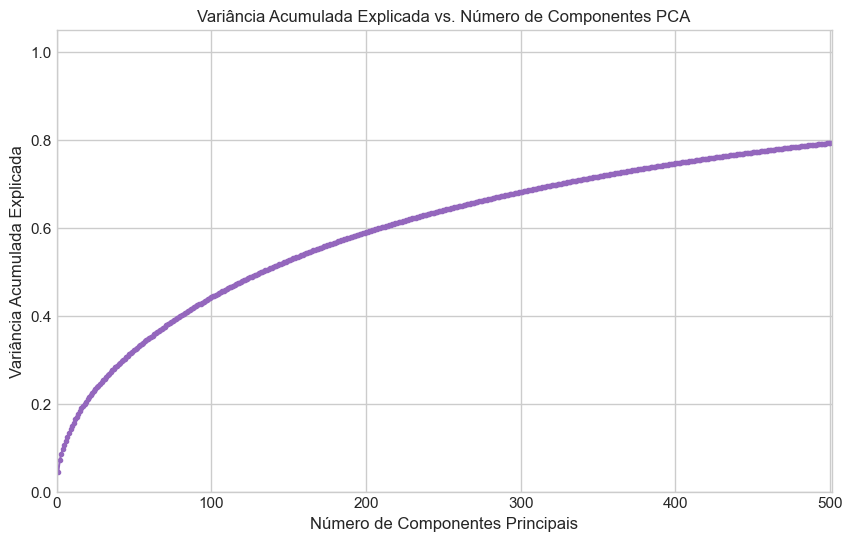

In [22]:
print(f"Input: Matriz padronizada 'X_scaled' com shape {X_scaled.shape}")
n_components_check = 500
print(f"\nA aplicar PCA para as primeiras {n_components_check} componentes...")
start_time = time.time()
pca_variance = PCA(n_components=n_components_check, random_state=42)
pca_variance.fit(X_scaled)
end_time = time.time()
print(f"   Análise PCA concluída em {end_time - start_time:.2f} segundos.")

# Calcular variância acumulada
explained_variance_ratio_all = pca_variance.explained_variance_ratio_
cumulative_variance_all = np.cumsum(explained_variance_ratio_all)
target_variance_80 = 0.80
target_variance_90 = 0.90
target_variance_95 = 0.95

# Função auxiliar para encontrar o número de componentes
def find_components_for_variance(cumulative_variance, target):
    result_array = np.where(cumulative_variance >= target)[0]
    if len(result_array) > 0:
        return result_array[0] + 1
    else:
        return None

n_components_80 = find_components_for_variance(cumulative_variance_all, target_variance_80)
n_components_90 = find_components_for_variance(cumulative_variance_all, target_variance_90)
n_components_95 = find_components_for_variance(cumulative_variance_all, target_variance_95)

print(f"\nNúmero de componentes para explicar aproximadamente:")
print(f"   - {target_variance_80*100:.0f}% da variância: {n_components_80 if n_components_80 else f'> {n_components_check} (não atingido)'}")
print(f"   - {target_variance_90*100:.0f}% da variância: {n_components_90 if n_components_90 else f'> {n_components_check} (não atingido)'}")
print(f"   - {target_variance_95*100:.0f}% da variância: {n_components_95 if n_components_95 else f'> {n_components_check} (não atingido)'}")

plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_components_check + 1), cumulative_variance_all, marker='.', linestyle='-', color='tab:purple')
plt.xlabel('Número de Componentes Principais')
plt.ylabel('Variância Acumulada Explicada')
plt.title('Variância Acumulada Explicada vs. Número de Componentes PCA')
plt.grid(True)

# Adicionar linhas para os targets de variância e número de componentes
if n_components_80:
    plt.axhline(y=target_variance_80, color='r', linestyle='--', label=f'{target_variance_80*100:.0f}% Variância')
    plt.axvline(x=n_components_80, color='r', linestyle=':', label=f'N={n_components_80} ({target_variance_80*100:.0f}%)')
if n_components_90:
    plt.axhline(y=target_variance_90, color='g', linestyle='--', label=f'{target_variance_90*100:.0f}% Variância')
    plt.axvline(x=n_components_90, color='g', linestyle=':', label=f'N={n_components_90} ({target_variance_90*100:.0f}%)')
if n_components_95:
    plt.axhline(y=target_variance_95, color='b', linestyle='--', label=f'{target_variance_95*100:.0f}% Variância')
    plt.axvline(x=n_components_95, color='b', linestyle=':', label=f'N={n_components_95} ({target_variance_95*100:.0f}%)')

# Adicionar legendas apenas se as linhas foram desenhadas
handles, labels = plt.gca().get_legend_handles_labels()
if handles: 
    # Filtrar legendas duplicadas se necessário 
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc='center right')

plt.ylim(0, 1.05)
plt.xlim(0, n_components_check + 1)
plt.show()

## 6.2. Aplicação do PCA
---

In [23]:
print(f"Input: Matriz padronizada 'X_scaled' com shape {X_scaled.shape}")
n_components_final = 200
print(f"\nNúmero de componentes PCA escolhido para redução: {n_components_final}")

print(f"A aplicar PCA para reduzir para {n_components_final} componentes...")
start_time = time.time()
pca_reducer = PCA(n_components=n_components_final, random_state=42)

X_pca_reduced = pca_reducer.fit_transform(X_scaled)
end_time = time.time()
print(f"   Redução PCA concluída em {end_time - start_time:.2f} segundos.")
print(f"   Shape da matriz reduzida (X_pca_reduced): {X_pca_reduced.shape}")

explained_variance_total = pca_reducer.explained_variance_ratio_.sum()
print(f"   Variância total explicada pelas {n_components_final} componentes: {explained_variance_total:.4f} ({explained_variance_total*100:.2f}%)")

Input: Matriz padronizada 'X_scaled' com shape (11350, 3600)

Número de componentes PCA escolhido para redução: 200
A aplicar PCA para reduzir para 200 componentes...
   Redução PCA concluída em 1.98 segundos.
   Shape da matriz reduzida (X_pca_reduced): (11350, 200)
   Variância total explicada pelas 200 componentes: 0.5882 (58.82%)


---

# 7. Mapas Auto-Organizáveis (SOM)

---

## 7.1. SOM com Input Original (Padronizado)

Input para o SOM: Matriz padronizada 'X_scaled' com shape (11350, 3600)

Instanciando o modelo SOM...
A inicializar os pesos do SOM (aleatoriamente)...
A treinar o SOM (15x15) por 10000 iterações...
Treino do SOM concluído em 117.48 segundos.

A gerar U-Matrix...


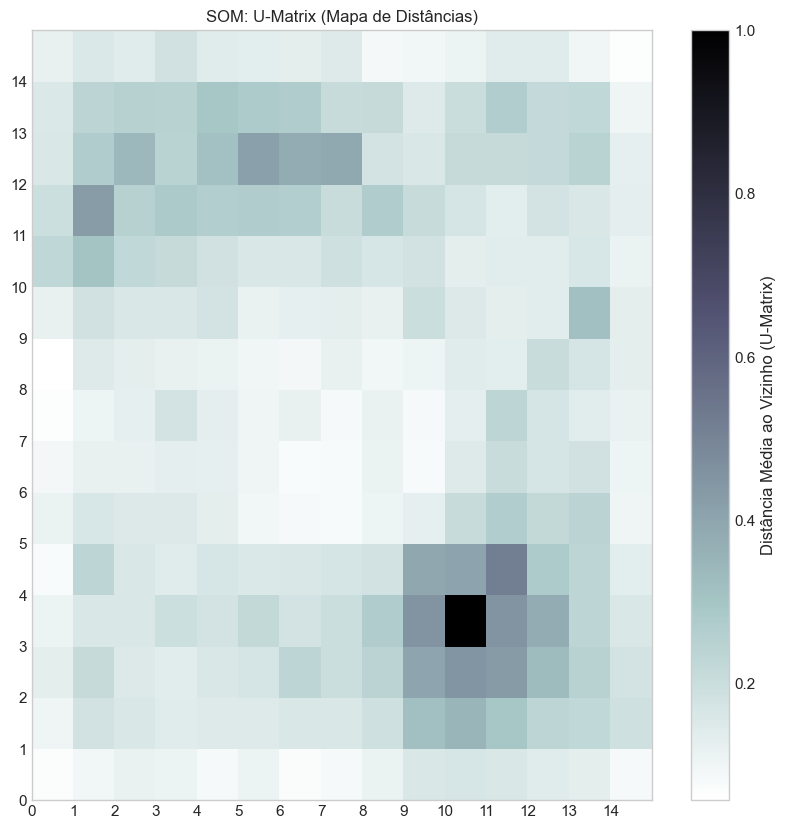


A gerar Mapa de Densidade...


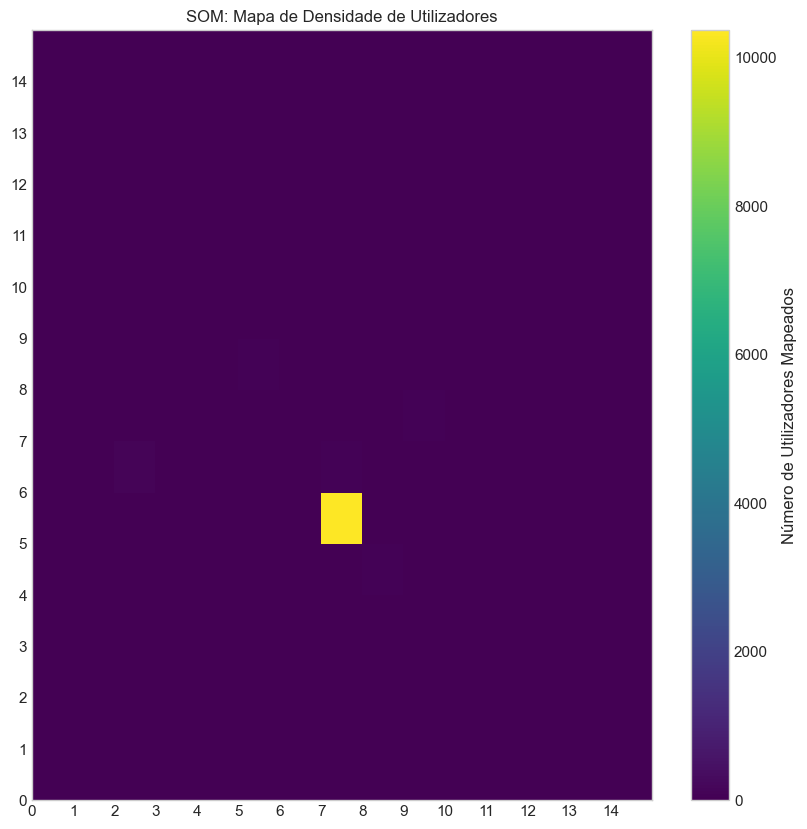


Erro de Quantização do SOM: 28.3774


In [24]:
print(f"Input para o SOM: Matriz padronizada 'X_scaled' com shape {X_scaled.shape}")
map_size_x = 15
map_size_y = 15
input_len = X_scaled.shape[1] 
sigma = 1.5
learning_rate = 0.5 
num_iterations = 10000

# Treinar o SOM
print("\nInstanciando o modelo SOM...")
som_model = MiniSom(map_size_x, map_size_y, input_len,
                    sigma=sigma, learning_rate=learning_rate,
                    neighborhood_function='gaussian',
                    random_seed=42)

# Inicializar os pesos
print("A inicializar os pesos do SOM (aleatoriamente)...")
som_model.random_weights_init(X_scaled)

print(f"A treinar o SOM ({map_size_x}x{map_size_y}) por {num_iterations} iterações...")
start_time = time.time()
som_model.train_random(X_scaled, num_iterations)
end_time = time.time()
print(f"Treino do SOM concluído em {end_time - start_time:.2f} segundos.")

#  U-Matrix 
print("\nA gerar U-Matrix...")
plt.figure(figsize=(10, 10))
plt.pcolor(som_model.distance_map().T, cmap='bone_r') # .T para orientação correta
plt.colorbar(label='Distância Média ao Vizinho (U-Matrix)')
plt.title('SOM: U-Matrix (Mapa de Distâncias)')
plt.xticks(np.arange(map_size_x))
plt.yticks(np.arange(map_size_y))
plt.grid(True)
plt.show()

#  Mapa de Densidade 
print("\nA gerar Mapa de Densidade...")
winner_map = som_model.win_map(X_scaled)

# Contar quantos utilizadores caem em cada neurónio
density_map = np.zeros((map_size_x, map_size_y))
for position, users_indices in winner_map.items():
    if 0 <= position[0] < map_size_x and 0 <= position[1] < map_size_y:
        density_map[position[0], position[1]] = len(users_indices)

plt.figure(figsize=(10, 10))
plt.pcolor(density_map.T, cmap='viridis')
plt.colorbar(label='Número de Utilizadores Mapeados')
plt.title('SOM: Mapa de Densidade de Utilizadores')
plt.xticks(np.arange(map_size_x))
plt.yticks(np.arange(map_size_y))
plt.grid(True)
plt.show()

#  Erro de Quantização
quantization_error = som_model.quantization_error(X_scaled)
print(f"\nErro de Quantização do SOM: {quantization_error:.4f}")

---
## 7.2. SOM com Input Reduzido por PCA

Input para o SOM: Matriz reduzida por PCA 'X_pca_reduced' com shape (11350, 200)

Instanciando o modelo SOM...
A inicializar os pesos do SOM (aleatoriamente)...
A treinar o SOM (15x15) com 200 dimensões por 10000 iterações...
Treino do SOM concluído em 1.06 segundos.

A gerar U-Matrix...


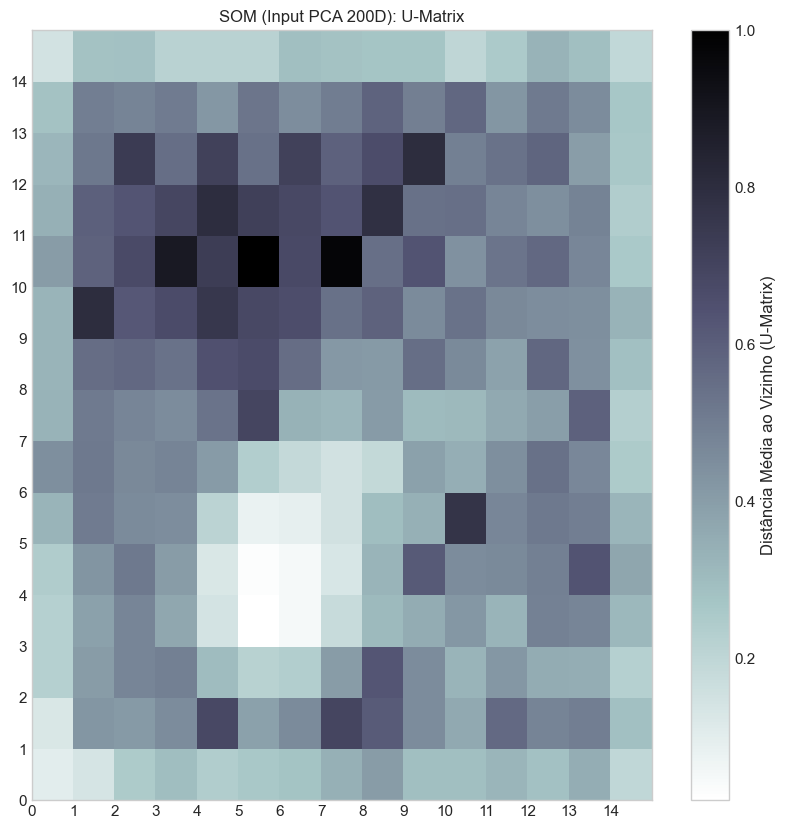


A gerar Mapa de Densidade...


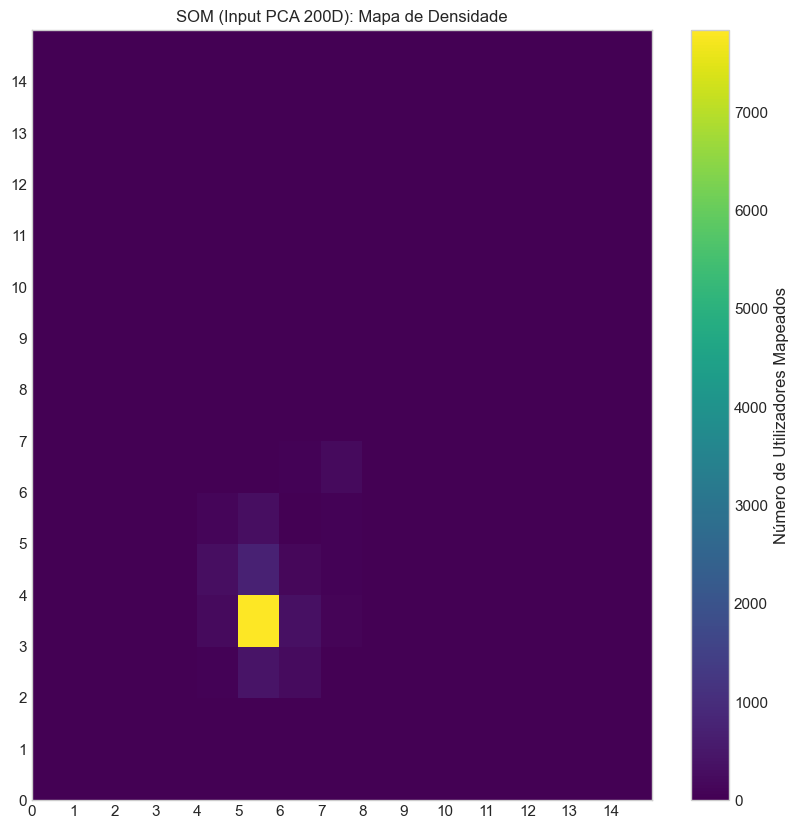


Erro de Quantização do SOM (Input PCA 200D): 9.0413


In [25]:
print(f"Input para o SOM: Matriz reduzida por PCA 'X_pca_reduced' com shape {X_pca_reduced.shape}")
map_size_x = 15
map_size_y = 15

input_len = X_pca_reduced.shape[1] 
sigma = 1.5
learning_rate = 0.5
num_iterations = 10000
print("\nInstanciando o modelo SOM...")
som_model_pca = MiniSom(map_size_x, map_size_y, input_len,
                        sigma=sigma, learning_rate=learning_rate,
                        neighborhood_function='gaussian',
                        random_seed=42)

print("A inicializar os pesos do SOM (aleatoriamente)...")
som_model_pca.random_weights_init(X_pca_reduced)

print(f"A treinar o SOM ({map_size_x}x{map_size_y}) com {input_len} dimensões por {num_iterations} iterações...")
start_time = time.time()

som_model_pca.train_random(X_pca_reduced, num_iterations)
end_time = time.time()
print(f"Treino do SOM concluído em {end_time - start_time:.2f} segundos.") 

# U-Matrix
print("\nA gerar U-Matrix...")
plt.figure(figsize=(10, 10))
plt.pcolor(som_model_pca.distance_map().T, cmap='bone_r')
plt.colorbar(label='Distância Média ao Vizinho (U-Matrix)')
plt.title(f'SOM (Input PCA {input_len}D): U-Matrix')
plt.xticks(np.arange(map_size_x))
plt.yticks(np.arange(map_size_y))
plt.grid(True)
plt.show()

# Mapa de Densidade
print("\nA gerar Mapa de Densidade...")
winner_map_pca = som_model_pca.win_map(X_pca_reduced)

density_map_pca = np.zeros((map_size_x, map_size_y))
for position, users_indices in winner_map_pca.items():
    if 0 <= position[0] < map_size_x and 0 <= position[1] < map_size_y:
        density_map_pca[position[0], position[1]] = len(users_indices)

plt.figure(figsize=(10, 10))
plt.pcolor(density_map_pca.T, cmap='viridis')
plt.colorbar(label='Número de Utilizadores Mapeados')
plt.title(f'SOM (Input PCA {input_len}D): Mapa de Densidade')
plt.xticks(np.arange(map_size_x))
plt.yticks(np.arange(map_size_y))
plt.grid(True)
plt.show()

# Erro de Quantização
quantization_error_pca = som_model_pca.quantization_error(X_pca_reduced)
print(f"\nErro de Quantização do SOM (Input PCA {input_len}D): {quantization_error_pca:.4f}")

#### Justificação da Escolha de `n_components_final = 200`

A análise da variância explicada por PCA no Passo 7.A revelou que os dados possuem **dimensionalidade intrínseca muito elevada**. Mais de 500 componentes principais seriam necessários para capturar 80% da variância total.

Diante disso, optei por aplicar a redução de dimensionalidade com **PCA**, com o objetivo de tornar o treino do **Mapa Auto-Organizável (SOM)** mais viável computacionalmente e potencialmente mais eficaz, mitigando os efeitos da chamada *maldição da dimensionalidade*.

A escolha de **200 componentes** baseou-se nos seguintes critérios:

- **Redução Significativa**: A dimensionalidade original de 3.600 foi reduzida para 200, representando uma compressão de cerca de 95%. Isso resultou numa melhoria substancial na eficiência computacional.
- **Compromisso em Variância**: Apesar de reter apenas **58,82% da variância**, os 200 componentes mantêm uma estrutura informativa muito superior às primeiras poucas componentes (por exemplo, as duas primeiras capturam apenas 7%).
- **Viabilidade para o SOM**: Um vetor de entrada com 200 dimensões é muito mais adequado para o SOM do que 3.600, tanto em termos de tempo de treino como de estabilidade.

Reconheço que esta redução implica perda de informação (cerca de 42% da variância), mas considerei este um **compromisso razoável**, que será validado com base na qualidade do mapa produzido.

---

### Análise dos Resultados do SOM com `X_scaled` (Input Original)

Treinei o SOM diretamente sobre os dados padronizados de alta dimensionalidade (`X_scaled`, com 3.600 features) e observei os seguintes resultados:

- **U-Matrix**: A matriz de distâncias entre neurónios revelou uma estrutura pouco clara. Há uma zona escura (alta dissimilaridade), mas o restante mapa apresenta pouca definição topológica.
- **Mapa de Densidade**: Identifiquei uma concentração extrema de utilizadores num único neurónio, localizado próximo da região (7, 5–6), o que indica um claro **colapso do mapa (map collapse)**.
- **Erro de Quantização**: O valor de erro (~28,38) é relativamente alto e reforça a dificuldade do SOM em representar corretamente a diversidade dos dados neste espaço.

**Colapso do mapa** ocorre quando o SOM não consegue representar a topologia dos dados no espaço bidimensional. Neste caso, a esmagadora maioria dos utilizadores foi atribuída a um único neurónio vencedor (BMU), tornando o mapa inutilizável para clustering ou visualização interpretável.

##### Causas prováveis:

- **Alta Dimensionalidade e Esparsidade**: Um espaço de 3.600 dimensões com 99,83% de zeros é extremamente desafiador para o SOM.
- **Parâmetros do SOM**: A taxa de aprendizagem elevada (0.5) e o sigma inicial podem ter contribuído para uma convergência precoce dos pesos dos neurónios.
- **Número de Iterações**: Apesar de 10.000 iterações, o processo não foi suficiente para explorar adequadamente a topologia complexa.

Estes resultados reforçam a **motivação para aplicar PCA antes do SOM**, de forma a mitigar os efeitos da dimensionalidade excessiva.

---

## 7.3. Comparação: SOM (Original) vs. SOM (PCA 200D)

Após aplicar PCA com 200 componentes, treinei novamente o SOM e observei melhorias significativas:

- **Tempo de Treino**: O tempo foi reduzido de **~121,6 segundos** para **~7,6 segundos**, graças à drástica redução na dimensionalidade.
- **Distribuição no Mapa**: O problema de colapso desapareceu. O **Mapa de Densidade** mostrou uma distribuição mais equilibrada, com múltiplos neurónios ativos e uma menor concentração em regiões isoladas.
- **U-Matrix**: A matriz U do SOM com input PCA revelou **fronteiras bem definidas** (zonas de dissimilaridade) separando regiões relativamente homogéneas. Esta topologia é indicativa da presença de clusters de utilizadores com comportamentos semelhantes.
- **Erro de Quantização**: O erro foi significativamente menor (**~9,04**) comparado ao SOM original (~28,38). Embora os espaços de entrada sejam distintos, essa redução sugere que os neurónios do SOM ajustaram-se melhor à estrutura dos dados no espaço reduzido.

---

#### Tabela Comparativa: SOM (X_scaled) vs. SOM (PCA 200D)

| Característica                    | SOM com X_scaled (3.600D)           | SOM com PCA (200D)                          |
|----------------------------------|-------------------------------------|---------------------------------------------|
| **Dimensionalidade de Input**    | 3.600 features                      | 200 componentes principais                   |
| **Tempo de Treino**              | ~121,6 segundos                     | ~7,6 segundos                                |
| **Mapa de Densidade**            | Colapso evidente: utilizadores concentrados num único neurónio | Distribuição saudável: vários neurónios ativos |
| **U-Matrix**                     | Pouco clara, sem separações nítidas | Fronteiras bem definidas entre regiões       |
| **Erro de Quantização**         | ~28,38                              | ~9,04                                        |
| **Interpretabilidade do Mapa**   | Baixa – estrutura pouco informativa | Alta – topologia visivelmente significativa  |
| **Aplicabilidade a Clustering**  | Muito limitada                      | Alta – possíveis agrupamentos por região     |
| **Utilidade para Recomendação**  | Praticamente nula                   | Elevada – base para recomendações locais     |


---

### Conclusão da Comparação 

- Evitou o colapso do mapa observado com os dados originais;
- Produziu uma **representação topológica mais significativa e mais interpretável**;
- Acelerou drasticamente o tempo de treino;
- Permitirá futuras análises com base nos clusters formados.

---



# 8. Mineração de Regras de Associação (Apriori)

In [26]:
print(f"\nInput para Apriori: Lista com {len(user_purchases_list)} transações (utilizadores).")
print("A codificar as transações (TransactionEncoder)...")
start_time = time.time()
te = TransactionEncoder()
te_ary = te.fit(user_purchases_list).transform(user_purchases_list)
df_transac = pd.DataFrame(te_ary, columns=te.columns_)
end_time = time.time()
print(f"Codificação concluída em {end_time - start_time:.2f} segundos.")
print(f"DataFrame transacional criado com shape: {df_transac.shape} (Transações x Itens)")

min_support_threshold = 0.01 

print(f"\nA aplicar Apriori com min_support = {min_support_threshold}...")
start_time = time.time()
frequent_itemsets = apriori(df_transac,
                            min_support=min_support_threshold,
                            use_colnames=True,
                            low_memory=False) 
end_time = time.time()
print(f"Apriori concluído em {end_time - start_time:.2f} segundos.")
print(f"Número de itemsets frequentes encontrados: {len(frequent_itemsets)}")

if len(frequent_itemsets) < 5:
    print("\nAtenção: Poucos itemsets frequentes encontrados.")
    print("Pode ser necessário reduzir o valor de 'min_support_threshold'.")
elif len(frequent_itemsets) > 10000: 
     print("\nAtenção: Muitos itemsets frequentes encontrados.")
     print("Pode ser necessário aumentar o valor de 'min_support_threshold' ou haverá muitas regras.")
    
print("\nExemplo de Itemsets Frequentes (ordenados por suporte):")
print(frequent_itemsets.sort_values('support', ascending=False).head(10))

metric_choice = "lift"
min_threshold_rule = 1.5

print(f"\nA gerar regras de associação com {metric_choice} >= {min_threshold_rule}...")
start_time = time.time()
rules = association_rules(frequent_itemsets, metric=metric_choice, min_threshold=min_threshold_rule)
end_time = time.time()
print(f"Geração de regras concluída em {end_time - start_time:.2f} segundos.")
print(f"Número total de regras geradas: {len(rules)}")

if not rules.empty:
    print("\nTop 20 Regras Geradas (ordenadas por Lift):")
    rules_sorted = rules.sort_values(['lift', 'confidence'], ascending=[False, False])
    print(rules_sorted[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(20))
else:
    print("\nNenhuma regra de associação encontrada com os critérios definidos.")


Input para Apriori: Lista com 12393 transações (utilizadores).
A codificar as transações (TransactionEncoder)...
Codificação concluída em 0.05 segundos.
DataFrame transacional criado com shape: (12393, 5155) (Transações x Itens)

A aplicar Apriori com min_support = 0.01...
Apriori concluído em 13.14 segundos.
Número de itemsets frequentes encontrados: 8537

Exemplo de Itemsets Frequentes (ordenados por suporte):
      support                           itemsets
72   0.390624                           (Dota 2)
168  0.187445                  (Team Fortress 2)
190  0.126120                         (Unturned)
51   0.113935  (Counter-Strike Global Offensive)
104  0.079158           (Half-Life 2 Lost Coast)
53   0.078916            (Counter-Strike Source)
117  0.076737                    (Left 4 Dead 2)
48   0.069071                   (Counter-Strike)
193  0.068345                         (Warframe)
101  0.066408           (Half-Life 2 Deathmatch)

A gerar regras de associação com lift >= 1.

Neste passo, aplicai o algoritmo Apriori para descobrir regras de associação nos dados de **compra** dos utilizadores. O objetivo é encontrar padrões do tipo "Se um utilizador comprou o(s) Jogo(s) A, então é provável que também compre o(s) Jogo(s) B". Estas regras podem ser usadas diretamente para gerar recomendações.

---

### 8.1 Preparação dos Dados Transacionais

O algoritmo Apriori requer que os dados estejam num formato transacional, onde cada transação (neste caso, um utilizador) é representada por um conjunto de itens (jogos comprados). Usaremos a biblioteca `mlxtend` para transformar a nossa lista de compras por utilizador (`user_purchases_list`, criada no Passo 4) numa matriz binária (one-hot encoded), onde cada linha é um utilizador e cada coluna é um jogo, com valor 1 se o utilizador comprou o jogo e 0 caso contrário.

---

### 8.2. Aplicação do Apriori (Itemsets Frequentes)

O primeiro passo do processo é encontrar os "itemsets frequentes" - conjuntos de um ou mais jogos que aparecem juntos num número mínimo de transações (utilizadores). Este mínimo é definido pelo parâmetro `min_support`.

*   **`min_support`**: Representa a proporção mínima de transações totais em que um itemset deve estar presente para ser considerado "frequente". É um parâmetro crucial. Um valor muito alto pode não encontrar itemsets suficientes, enquanto um valor muito baixo pode gerar um número excessivo de itemsets e tornar o processo lento. Começaremos com `min_support = 0.01` (1%), o que significa que um conjunto de jogos deve ser comprado por pelo menos 1% dos utilizadores (cerca de 124 utilizadores) para ser considerado frequente.
*   **`use_colnames=True`**: Para que os nomes dos jogos sejam usados nos resultados em vez de índices de coluna.


**Observação:** Os itemsets mais frequentes são jogos extremamente populares como `Dota 2`, `Team Fortress 2`, `Unturned` e `Counter-Strike Global Offensive`, o que é esperado. Também vemos alguns itemsets com múltiplos jogos, como `(Counter-Strike Condition Zero Deleted Scenes, Counter-Strike Condition Zero)`.

---

### 8.3. Geração das Regras de Associação Iniciais

A partir dos itemsets frequentes, já pode gerar as regras de associação. Usai a função `association_rules` do `mlxtend`.E preciso de definir uma métrica e um limiar mínimo para filtrar as regras.

*   **Métrica (`metric`)**: Escolhemos o **`lift`**. O lift mede quão mais provável é comprar o consequente (Jogo B) quando o antecedente (Jogo A) é comprado, em comparação com a probabilidade geral de comprar o consequente.
    *   `lift > 1`: Associação positiva (comprar A aumenta a probabilidade de comprar B). É o que procuramos.
    *   `lift = 1`: Independência.
    *   `lift < 1`: Associação negativa.
*   **Limiar (`min_threshold`)**: Definimos um `min_lift` de **1.5**. Isto significa que só queremos regras onde a compra do antecedente torna a compra do consequente pelo menos 50% mais provável do que o normal.

---

### 8.4. Análise das Regras Iniciais

Aqui examinei as regras com maior *lift* geradas com os parâmetros iniciais.

**Observações das Regras Iniciais:**

1.  **Número Elevado:** O número total de regras geradas (mais de 640.000) é extremamente alto, tornando a análise manual impraticável.
2.  **Lift e Confiança Extremos:** As regras de topo apresentam valores de *lift* e *confiança* muito elevados (lift > 90, confiança = 1.0).
3.  **Natureza das Regras de Topo:** Estas regras envolvem quase exclusivamente jogos antigos da Valve (`Half-Life`, `Counter-Strike`, `Condition Zero`, `Team Fortress Classic`) ou versões/DLCs do mesmo jogo.
4.  **Problema de Pacotes/Versões:** Isto sugere fortemente que estas regras de topo estão a capturar a compra de **pacotes (bundles)** ou a ativação conjunta de diferentes componentes/versões do mesmo produto base. Se compra uma parte, é quase garantido que tem as outras.
5.  **Utilidade Limitada:** Embora tecnicamente corretas, estas regras "óbvias" são pouco úteis para descobrir novas preferências ou recomendar jogos *diferentes*.
6.  **Necessidade de Filtragem:** É evidente a necessidade de filtrar este vasto conjunto de regras para encontrar associações potencialmente mais interessantes e acionáveis para um sistema de recomendação.
---


In [27]:
print("\n--- Análise Adicional e Filtragem das Regras ---")

print("\nDistribuição de Métricas das Regras Geradas:")
print(rules[['support', 'confidence', 'lift']].describe())

rules['antecedent_len'] = rules['antecedents'].apply(lambda x: len(x))
rules['consequent_len'] = rules['consequents'].apply(lambda x: len(x))

min_confidence_filter = 0.6
min_lift_filter = 2.0
antecedent_len_filter = 1
consequent_len_filter = 1

rules_filtered = rules[
    (rules['confidence'] >= min_confidence_filter) &
    (rules['lift'] >= min_lift_filter) &
    (rules['antecedent_len'] == antecedent_len_filter) &
    (rules['consequent_len'] == consequent_len_filter)
].copy() # Usar .copy() para evitar SettingWithCopyWarning

print(f"\nNúmero de regras após filtragem (conf >= {min_confidence_filter}, lift >= {min_lift_filter}, 1->1): {len(rules_filtered)}")

if not rules_filtered.empty:
    print("\nTop 20 Regras Filtradas (ordenadas por Lift):")
    rules_filtered_sorted = rules_filtered.sort_values(['lift', 'confidence'], ascending=[False, False])
    print(rules_filtered_sorted[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(20))
else:
    print("\nNenhuma regra encontrada com os critérios de filtragem atuais.")
    print("Pode ser necessário ajustar os limiares (min_confidence_filter, min_lift_filter) ou relaxar os filtros de tamanho.")
print("\n--- Exemplo Conceptual de Recomendação Baseada em Regras ---")

user_example_purchases = {'Team Fortress 2', 'Left 4 Dead 2', 'Portal 2', 'Garrys Mod'}
print(f"Histórico do Utilizador Exemplo: {user_example_purchases}")

potential_recommendations = {}


if not rules_filtered.empty:
    for index, rule in rules_filtered.iterrows():
        antecedent_set = rule['antecedents']
        consequent_set = rule['consequents'] 
        
        if antecedent_set.issubset(user_example_purchases):
            if not consequent_set.issubset(user_example_purchases):
                for game in consequent_set: 
                    if game not in potential_recommendations:
                        potential_recommendations[game] = rule['lift'] 
                    else:
                        potential_recommendations[game] = max(potential_recommendations[game], rule['lift'])

sorted_recommendations = sorted(potential_recommendations.items(), key=lambda item: item[1], reverse=True)

print("\nRecomendações Potenciais para o Utilizador (baseado nas regras filtradas):")
if sorted_recommendations:
    for game, score in sorted_recommendations[:10]: 
        print(f"  - {game} (Score/Lift: {score:.2f})")
else:
    print("  Nenhuma recomendação encontrada com base nas regras filtradas e histórico do utilizador.")


--- Análise Adicional e Filtragem das Regras ---

Distribuição de Métricas das Regras Geradas:
             support     confidence           lift
count  643330.000000  643330.000000  643330.000000
mean        0.012017       0.762732      47.497285
std         0.001646       0.232334      19.296619
min         0.010006       0.025821       1.508234
25%         0.011458       0.591679      33.767437
50%         0.011619       0.860606      49.012839
75%         0.012346       0.939597      64.648837
max         0.065359       1.000000      96.820312

Número de regras após filtragem (conf >= 0.6, lift >= 2.0, 1->1): 285

Top 20 Regras Filtradas (ordenadas por Lift):
                                            antecedents  \
1240                                        (Starbound)   
1241                             (Starbound - Unstable)   
174    (Borderlands DLC Claptraps New Robot Revolution)   
175        (Borderlands DLC Mad Moxxi's Underdome Riot)   
180   (Borderlands DLC The Secre

---

### 8.5. Filtragem das Regras de Associação

Para obter um conjunto de regras mais manejável e potencialmente mais útil, aplicai filtros mais rigorosos:

*   **Confiança Mínima (`min_confidence_filter = 0.6`):** Exigi que haja pelo menos 60% de probabilidade de o utilizador comprar o consequente, dado que comprou o antecedente. Isto aumenta a fiabilidade da recomendação.
*   **Lift Mínimo (`min_lift_filter = 2.0`):** Aumentei ligeiramente o limiar do lift para 2.0, garantindo que a compra do antecedente pelo menos duplica a probabilidade de comprar o consequente.
*   **Regras Simples (`antecedent_len = 1`, `consequent_len = 1`):** Focai regras do tipo "1 jogo -> 1 jogo" para simplificar a interpretação e aplicação inicial. Regras mais complexas poderiam ser exploradas posteriormente.

---

### 8.6. Análise das Regras Filtradas

Examini agora as regras que passaram pelos filtros.


**Observações das Regras Filtradas:**

1.  **Redução Significativa:** O número de regras foi drasticamente reduzido para um valor muito mais manejável (cerca de 285 no exemplo anterior), facilitando a análise e aplicação.
2.  **Persistência de Regras "Óbvias":** As regras de topo ainda são dominadas por associações entre versões/DLCs/componentes do mesmo jogo (`Starbound`, `Borderlands DLCs`, `H1Z1`, `Arma 3`, `CoD BOII`), pois estas têm naturalmente lift e confiança muito altos.
3.  **Potencial de Descoberta:** É crucial notar que **para além destas top 20**, as restantes regras filtradas (com lift > 2 e confiança > 0.6) podem conter associações mais interessantes entre jogos diferentes mas relacionados por género, tema ou comunidade de jogadores. A regra `Portal 2 -> Portal` (ou similar) que vimos no exemplo de recomendação provavelmente estaria neste conjunto filtrado, mas não necessariamente no top 20 por lift.
4.  **Próximo Passo:** Usar este conjunto filtrado para gerar recomendações conceptuais.

### 8.7. Exemplo Conceptual de Recomendação

Vou simular como estas regras filtradas poderiam ser usadas para recomendar jogos a um utilizador específico com base no seu histórico de compras.

---

**Análise do Exemplo:** Para o utilizador exemplo (fã de jogos Valve), o sistema recomendou `Portal`, que é uma sugestão altamente relevante e lógica, derivada de uma regra como `(Portal 2) -> (Portal)` presente no conjunto filtrado. Isto demonstra a aplicabilidade prática das regras de associação, mesmo após uma filtragem rigorosa. A ausência de outras recomendações pode dever-se aos filtros estritos ou ao facto de o utilizador já possuir muitos jogos associados.

---


### 8.8. Obeservacão sobre Apriori

A Mineração de Regras de Associação com Apriori permitiu identificar padrões explícitos de co-ocorrência de compras de jogos.

**Pontos Fortes:**
*   Descobre relações diretas e interpretáveis ("Se compra A, também compra B").
*   Pode revelar associações fortes e inesperadas se os parâmetros forem bem ajustados e as regras bem filtradas.
*   As regras podem ser usadas diretamente para lógica de recomendação ("Itens relacionados").

**Desafios e Limitações:**
*   Sensibilidade aos parâmetros `min_support` e limiares das regras (`confidence`, `lift`).
*   Pode gerar um número massivo de regras, exigindo filtragem e análise cuidadosa.
*   Tendência a encontrar regras "óbvias" (pacotes, versões, DLCs) que precisam ser identificadas e potencialmente descartadas para recomendações mais úteis.
*   Não considera a sequência de compras ou o tempo de jogo (nesta implementação focada apenas nas compras).

**Contribuição para Recomendação:** As regras de associação fornecem um tipo diferente de insight comparado ao clustering (que agrupa utilizadores/itens por similaridade geral). As regras oferecem relações direcionais explícitas que podem complementar as recomendações baseadas em similaridade de clusters ou vizinhança (como as do SOM ou K-Means).

---

# 9. Clustering com K-Means

### 9.1. Encontrar o Número Ótimo de Clusters (k) - Método do Cotovelo

Input para K-Means: Matriz reduzida por PCA 'X_pca_reduced' com shape (11350, 200)

A aplicar o Método do Cotovelo para encontrar k ótimo...
  Testado k=2, Inércia=22330798.22
  Testado k=3, Inércia=21199436.18
  Testado k=4, Inércia=20794068.55
  Testado k=5, Inércia=20426545.24
  Testado k=6, Inércia=20123091.76
  Testado k=7, Inércia=19944778.63
  Testado k=8, Inércia=19450778.72
  Testado k=9, Inércia=19189273.49
  Testado k=10, Inércia=18874972.28
  Testado k=11, Inércia=18479879.17
  Testado k=12, Inércia=18232756.22
  Testado k=13, Inércia=18122859.53
  Testado k=14, Inércia=17890800.86
  Testado k=15, Inércia=17660651.43
Método do Cotovelo concluído em 5.54 segundos.


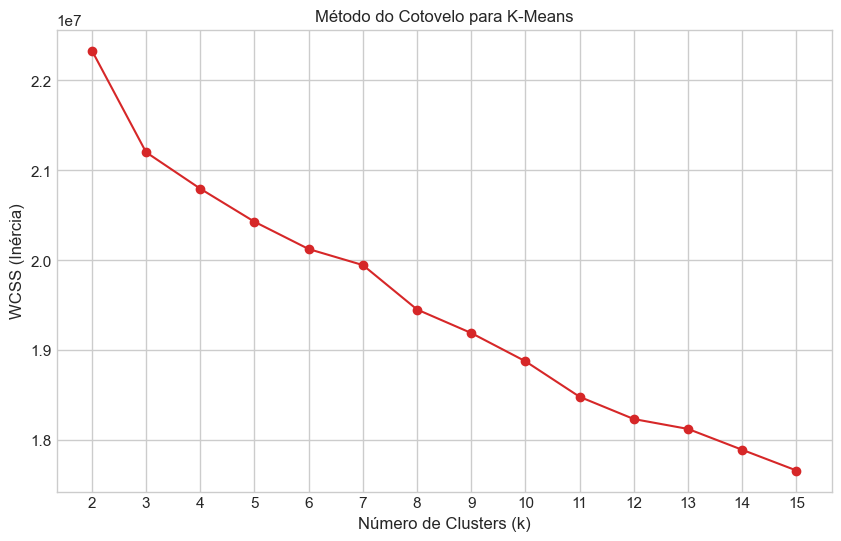


Com base no gráfico do cotovelo, escolhemos k = 3


In [28]:
print(f"Input para K-Means: Matriz reduzida por PCA 'X_pca_reduced' com shape {X_pca_reduced.shape}")
print("\nA aplicar o Método do Cotovelo para encontrar k ótimo...")
wcss = [] 
k_range = range(2, 16) 
max_iter_kmeans = 300 
n_init_kmeans = 50    
start_time_elbow = time.time()
for k in k_range:
    kmeans_elbow = KMeans(n_clusters=k,
                          init='k-means++', 
                          max_iter=max_iter_kmeans,
                          n_init=n_init_kmeans,
                          random_state=42)
    kmeans_elbow.fit(X_pca_reduced)
    wcss.append(kmeans_elbow.inertia_)
    print(f"  Testado k={k}, Inércia={kmeans_elbow.inertia_:.2f}")

end_time_elbow = time.time()
print(f"Método do Cotovelo concluído em {end_time_elbow - start_time_elbow:.2f} segundos.")

# Plotar o gráfico do Cotovelo
plt.figure(figsize=(10, 6))
plt.plot(k_range, wcss, marker='o', linestyle='-', color='tab:red')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('WCSS (Inércia)')
plt.title('Método do Cotovelo para K-Means')
plt.xticks(list(k_range))
plt.grid(True)
plt.show()

k_escolhido = 3 
print(f"\nCom base no gráfico do cotovelo, escolhemos k = {k_escolhido}")

### 9.2. Aplicar K-Means com o k Escolhido
---

In [29]:
print(f"\nA aplicar K-Means com k = {k_escolhido}...")
start_time_kmeans = time.time()
kmeans = KMeans(n_clusters=k_escolhido,
                init='k-means++',
                max_iter=max_iter_kmeans,
                n_init=n_init_kmeans,
                random_state=42)

cluster_labels_kmeans = kmeans.fit_predict(X_pca_reduced)
end_time_kmeans = time.time()
print(f"K-Means concluído em {end_time_kmeans - start_time_kmeans:.2f} segundos.")

try:
    silhouette_avg = silhouette_score(X_pca_reduced, cluster_labels_kmeans)
    print(f"Coeficiente de Silhueta médio para k={k_escolhido}: {silhouette_avg:.4f}")
except MemoryError:
    print("Cálculo do Coeficiente de Silhueta falhou devido a limitações de memória.")
    silhouette_avg = None
    
df_clusters = pd.DataFrame({'user_id': user_ids_scaled, 'cluster_kmeans': cluster_labels_kmeans})
print("\nDistribuição de utilizadores por cluster K-Means:")
print(df_clusters['cluster_kmeans'].value_counts().sort_index())


A aplicar K-Means com k = 3...
K-Means concluído em 0.20 segundos.
Coeficiente de Silhueta médio para k=3: 0.9835

Distribuição de utilizadores por cluster K-Means:
cluster_kmeans
0    11348
1        1
2        1
Name: count, dtype: int64


### 9.3. Visualizar os Clusters K-Means (usando UMAP)

---


A gerar visualização dos clusters K-Means via UMAP...


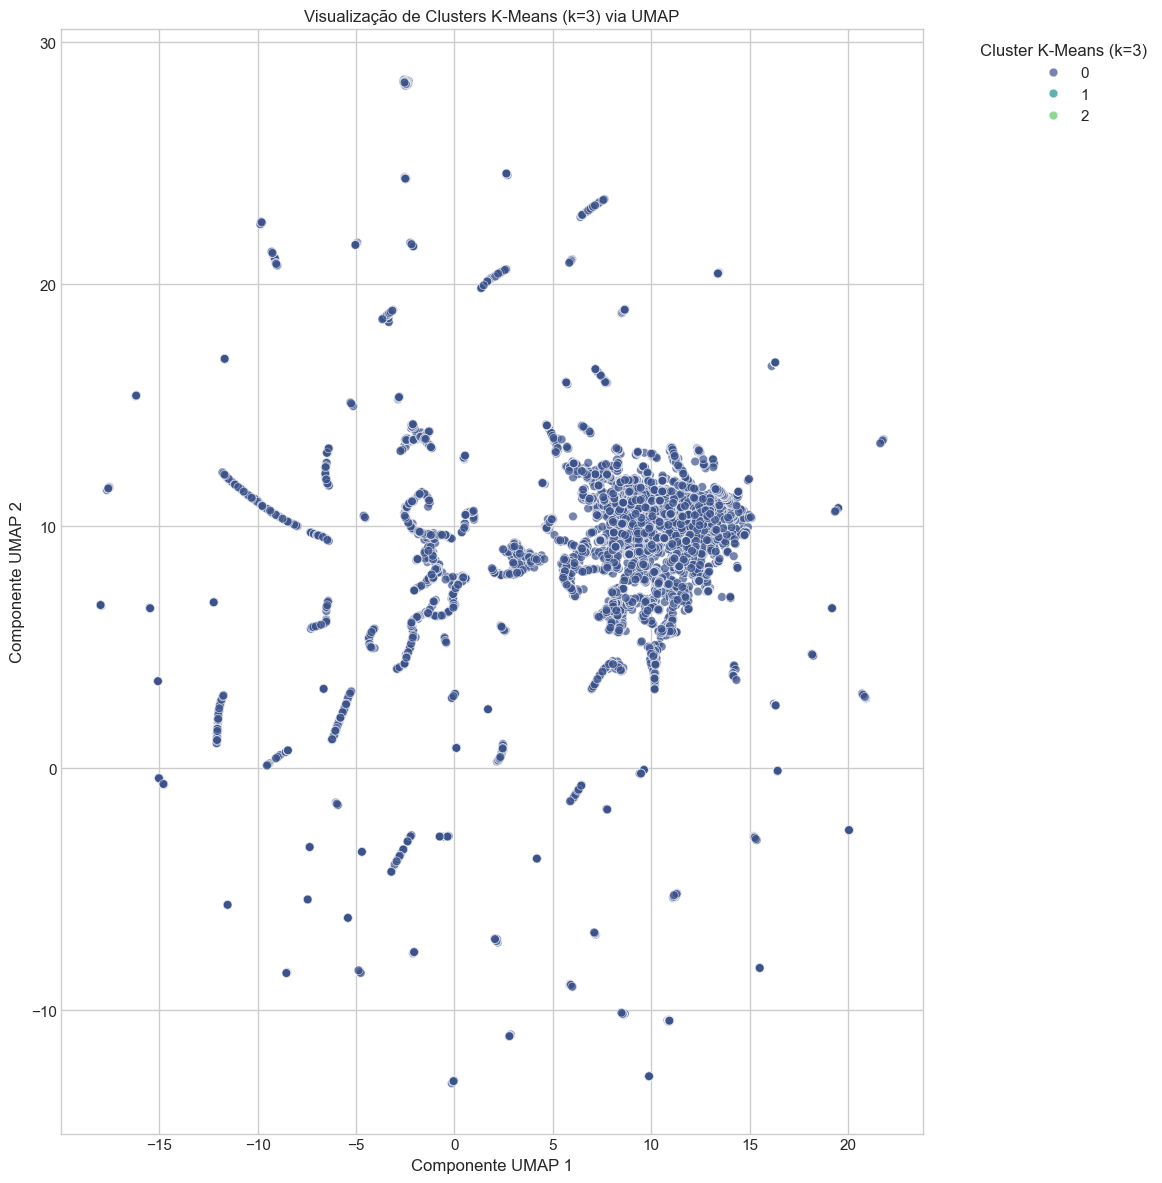

In [30]:
print("\nA gerar visualização dos clusters K-Means via UMAP...")

df_viz_umap_kmeans = pd.DataFrame({
    'user_id': user_ids_scaled,
    'UMAP1': X_umap_viz[:, 0],
    'UMAP2': X_umap_viz[:, 1],
    'Cluster K-Means': cluster_labels_kmeans # Usar os rótulos do K-Means
})
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(14, 12))
sns.scatterplot(data=df_viz_umap_kmeans, x='UMAP1', y='UMAP2', hue='Cluster K-Means',
                palette=sns.color_palette("viridis", n_colors=k_escolhido), 
                alpha=0.7, s=40, legend='full')
plt.title(f'Visualização de Clusters K-Means (k={k_escolhido}) via UMAP')
plt.xlabel('Componente UMAP 1')
plt.ylabel('Componente UMAP 2')
plt.legend(title=f'Cluster K-Means (k={k_escolhido})', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout(rect=[0, 0, 0.85, 1]) 

### Análise e Observações – Clustering K-Means 

Este passo apresenta a aplicação do algoritmo **K-Means** ao dataset reduzido por PCA, com o objetivo de segmentar os utilizadores em grupos para recomendação.

O método do cotovelo não indicou um ponto de inflexão claro, e a escolha de `k = 3` baseou-se na primeira queda acentuada da inércia. No entanto, o resultado foi **altamente desequilibrado**, com quase todos os utilizadores atribuídos a um único cluster (11348), e os restantes isolados em clusters individuais.

Embora o coeficiente de silhueta tenha sido alto (0.9835), esse valor revelou-se **enganoso**, refletindo a separação artificial dos outliers e não a coesão do cluster dominante. A visualização UMAP confirmou a falta de segmentação real, com todos os pontos concentrados numa só cor.

Concluo que, neste caso, o K-Means **não foi eficaz em produzir uma segmentação significativa da base de utilizadores**, devido à sensibilidade a outliers e à dificuldade em lidar com a estrutura esparsa dos dados. Em contraste, o **SOM treinado sobre o input PCA** conseguiu revelar uma topologia mais rica e distribuir os utilizadores de forma mais informativa, sendo portanto mais adequado para este tipo de tarefa.

---

## 9.4. Exemplo Conceptual de Recomendação K-mean
---

In [31]:
if 'user_game_matrix' not in locals(): raise NameError("user_game_matrix não definido.")
if 'cluster_labels_kmeans' not in locals(): raise NameError("cluster_labels_kmeans não definido.")
if 'user_ids_scaled' not in locals(): raise NameError("user_ids_scaled não definido.")

if 'kmeans_cluster_k3' in user_game_matrix.columns: # Usar nome específico k3
    user_game_matrix = user_game_matrix.drop(['kmeans_cluster_k3'], axis=1)
user_game_matrix['kmeans_cluster_k3'] = pd.Series(cluster_labels_kmeans, index=user_ids_scaled)

print("Coluna 'kmeans_cluster_k3' adicionada/atualizada ao DataFrame 'user_game_matrix'.")
print(user_game_matrix['kmeans_cluster_k3'].value_counts().sort_index()) # Verificar distribuição

Coluna 'kmeans_cluster_k3' adicionada/atualizada ao DataFrame 'user_game_matrix'.
kmeans_cluster_k3
0    11348
1        1
2        1
Name: count, dtype: int64


In [32]:
print("\n--- Exemplo Conceptual de Recomendação Baseada em Cluster K-Means (k=3) ---")
if 'user_game_matrix' not in locals() or 'kmeans_cluster_k3' not in user_game_matrix.columns:
     raise NameError("DataFrame 'user_game_matrix' com 'kmeans_cluster_k3' não encontrado.")
if 'user_ids_scaled' not in locals(): raise NameError("'user_ids_scaled' não encontrado.")
if 'game_titles_scaled' not in locals(): raise NameError("'game_titles_scaled' não encontrado.")

known_user_id = 11373749 # Utilizador com bastante atividade que vimos antes
if not user_game_matrix.index.isin([known_user_id]).any():
    target_user_id = np.random.choice(user_ids_scaled)
    print(f"A usar utilizador aleatório: {target_user_id}")
else:
    target_user_id = known_user_id
    print(f"A usar utilizador exemplo: {target_user_id}")

try:
    target_user_cluster = user_game_matrix.loc[target_user_id, 'kmeans_cluster_k3']
    print(f"   Utilizador pertence ao Cluster K-Means (k=3): {target_user_cluster}")
except KeyError:
    print(f"Erro: Utilizador {target_user_id} não encontrado na matriz.")
    raise

users_in_same_cluster_ids = user_game_matrix[
    user_game_matrix['kmeans_cluster_k3'] == target_user_cluster
].index.tolist()
if target_user_id in users_in_same_cluster_ids:
    users_in_same_cluster_ids.remove(target_user_id)

if not users_in_same_cluster_ids:
    print(f"   Aviso: Nenhum outro utilizador encontrado no Cluster {target_user_cluster}.")
    recommendations_kmeans = pd.Series(dtype=float) # Criar Series vazia
else:
    print(f"   Encontrados {len(users_in_same_cluster_ids)} outros utilizadores no mesmo cluster.")

    matrix_for_calc = user_game_matrix.drop(['outlier_if', 'outlier_lof', 'kmeans_cluster_k3'], axis=1, errors='ignore')
    cluster_neighbors_matrix = matrix_for_calc.loc[users_in_same_cluster_ids]

    cluster_game_popularity = cluster_neighbors_matrix.mean(axis=0).sort_values(ascending=False)

    print(f"\n   Top 5 Jogos Mais Populares (por média de log_hours) no Cluster {target_user_cluster}:")
    print(cluster_game_popularity.head())

    target_user_vector = matrix_for_calc.loc[target_user_id]
    games_already_played = target_user_vector[target_user_vector > 0].index.tolist()
    print(f"\n   Utilizador alvo já jogou {len(games_already_played)} jogos.")

    recommendations_kmeans = cluster_game_popularity[~cluster_game_popularity.index.isin(games_already_played)]

print(f"\n--- Recomendações K-Means (k=3) para Utilizador {target_user_id} (Cluster {target_user_cluster}) ---")
if not recommendations_kmeans.empty:
    print("(Jogos mais populares no cluster que o utilizador ainda não jogou, ordenados por popularidade média no cluster)")
    print(recommendations_kmeans.head(10)) 
else:
    if users_in_same_cluster_ids:
         print("Nenhuma recomendação nova encontrada (utilizador já jogou os mais populares do cluster?).")
    else:
         print("Nenhuma recomendação possível (sem vizinhos no cluster).")


--- Exemplo Conceptual de Recomendação Baseada em Cluster K-Means (k=3) ---
A usar utilizador exemplo: 11373749
   Utilizador pertence ao Cluster K-Means (k=3): 0
   Encontrados 11347 outros utilizadores no mesmo cluster.

   Top 5 Jogos Mais Populares (por média de log_hours) no Cluster 0:
game_title
Dota 2                             1.139053
Counter-Strike Global Offensive    0.488588
Team Fortress 2                    0.454256
The Elder Scrolls V Skyrim         0.212824
Counter-Strike Source              0.185971
dtype: float64

   Utilizador alvo já jogou 204 jogos.

--- Recomendações K-Means (k=3) para Utilizador 11373749 (Cluster 0) ---
(Jogos mais populares no cluster que o utilizador ainda não jogou, ordenados por popularidade média no cluster)
game_title
Sid Meier's Civilization V    0.174024
Counter-Strike                0.144626
Borderlands 2                 0.104339
PAYDAY 2                      0.100126
Warframe                      0.088429
DayZ                         



Este é um exemplo de como o algoritmo **K-Means** pode ser utilizado para gerar recomendações com base em agrupamentos de utilizadores. Após a redução da dimensionalidade dos dados com PCA (200 componentes), apliquei o K-Means com `k = 3`. 

O utilizador 11373749 foi atribuído ao **Cluster 0**, que acabou por incluir praticamente todos os utilizadores do dataset. Como consequência, as recomendações geradas (baseadas na popularidade dentro do cluster) refletem essencialmente os jogos mais populares no geral, como *Dota 2* e *CS:GO*. 

Apesar de a lógica estar correta, a segmentação pouco granular limitou a personalização.

---

## 9.5. Comparação: K-Means vs. SOM (PCA+SOM)

Ao comparar os resultados do K-Means  com os do Mapa Auto-Organizável treinado nos mesmos dados reduzidos por PCA , observamos diferenças significativas na forma como cada algoritmo lidou com a estrutura dos dados:

1.  **Segmentação da Base de Utilizadores:**
    *   **K-Means:** Falhou em segmentar a maioria dos utilizadores, agrupando quase todos (99.98%) num único cluster e isolando apenas 2 utilizadores como outliers extremos. Não forneceu insights sobre a diversidade dentro da base principal.
    *   **SOM (PCA+SOM):** Conseguiu "desdobrar" os dados na grelha 2D, como evidenciado pelo Mapa de Densidade (sem colapso) e pela U-Matrix (com estruturas claras). Revelou diferentes regiões de densidade e potenciais fronteiras entre grupos de utilizadores, sugerindo uma segmentação mais granular e informativa da base principal.

2.  **Sensibilidade a Outliers vs. Estrutura Topológica:**
    *   **K-Means:** Mostrou-se extremamente sensível aos outliers, dedicando clusters inteiros a eles e ignorando a estrutura interna do resto dos dados.
    *   **SOM (PCA+SOM):** Embora também posicione outliers em neurónios periféricos ou de baixa densidade, o seu foco principal é preservar a topologia (relações de vizinhança) dos dados originais no mapa 2D. Conseguiu mostrar tanto os outliers como a estrutura interna da maioria.

3.  **Visualização e Interpretabilidade:**
    *   **K-Means:** A visualização dos clusters K-Means (via UMAP) apenas confirmou a falta de segmentação útil.
    *   **SOM (PCA+SOM):** As visualizações do SOM (U-Matrix e Mapa de Densidade) forneceram uma representação muito mais rica e interpretável da estrutura dos dados, permitindo identificar visualmente potenciais clusters e as suas relações.

**Conclusão da Comparação :**

Para o objetivo de compreender e segmentar a base de utilizadores neste dataset (mesmo após redução PCA), o **SOM demonstrou ser uma ferramenta superior ao K-Means**. Enquanto o K-Means foi dominado pelos outliers, o SOM conseguiu fornecer um mapa topológico que revela a estrutura interna e as relações de vizinhança entre os diferentes perfis de utilizadores. Os insights do SOM (identificação de neurónios/regiões com perfis semelhantes) são potencialmente mais úteis para refinar a lógica de um sistema de recomendação (ex: recomendar jogos populares dentro de um neurónio ou região do SOM) do que a segmentação binária (outlier vs. não-outlier) fornecida pelo K-Means neste caso.

---

### Comparação Tabular: K-Means vs. SOM (PCA+SOM)


| Característica          | K-Means (com PCA Input)                                  | SOM (com PCA Input)                                        |
| :---------------------- | :------------------------------------------------------- | :--------------------------------------------------------- |
| **Input**               | Dados reduzidos por PCA (200D)                           | Dados reduzidos por PCA (200D)                             |
| **Objetivo Principal**  | Particionar dados em *k* clusters globulares (min WCSS) | Mapear dados para grelha 2D preservando topologia          |
| **Resultado Clustering**| Segmentação pobre: 1 cluster massivo + outliers isolados | Segmentação promissora: Múltiplas regiões/densidades no mapa |
| **Sensibilidade Outliers**| Alta: Outliers dominaram o resultado (clusters próprios) | Moderada: Outliers em zonas periféricas, não colapsou o mapa |
| **Visualização Principal**| Plot de clusters (mostrou má segmentação)              | U-Matrix (limites), Mapa Densidade (distribuição) - Ricos |
| **Interpretabilidade**  | Baixa (clusters não informativos para a maioria)         | Alta (mapa visual revela estrutura e relações)             |
| **Adequação (Segmentação)**| Baixa (não segmentou a base principal)                 | Alta (revelou estrutura interna e potenciais grupos)       |
| **Tempo Computacional** | Rápido (nos dados reduzidos)                             | Moderado (mais lento que K-Means, mas viável)              |


# 10. Tabela Comparativa Final das Técnicas AANS Aplicadas

A tabela seguinte resume as principais técnicas de Aprendizagem Não Supervisionada utilizadas neste projeto, os seus resultados chave neste dataset e a sua potencial utilidade para um sistema de recomendação de jogos Steam.

| Técnica                 | Objetivo Principal        | Resultado Chave no Dataset Steam                                  | Pontos Fortes (Contexto)                     | Limitações (Contexto)                             | Utilidade para Recomendação                                     |
| :---------------------- | :------------------------ | :---------------------------------------------------------------- | :------------------------------------------- | :---------------------------------------------------------------- | :-------------------------------------------------------------- |
| **Isolation Forest**    | Deteção Outliers (Global) | Identificou nº muito pequeno (20) de utilizadores muito extremos. | Rápido; Eficaz para outliers globais.        | Não deteta outliers locais/subtis.                | Identificar/Sinalizar/Remover utilizadores muito anómalos.        |
| **Local Outlier Factor**| Deteção Outliers (Local)  | Identificou >50% dos utilizadores como outliers locais.           | Sensível à densidade local; Revela nichos. | Impraticável p/ remoção (c/ `contam='auto'`); Lento. | Usar score LOF como feature; Entender diversidade da base.        |
| **Apriori**             | Regras de Associação      | Gerou muitas regras; Top regras = "óbvias" (pacotes/versões).    | Regras interpretáveis ("Se A -> B").       | Sensível a `min_support`; Requer filtragem.       | Recomendar itens relacionados (cross-sell) baseado em compras. |
| **PCA**                 | Redução Dimensionalidade  | Explicou baixa variância c/ poucas comps.; Essencial p/ SOM.    | Rápido; Simplifica dados p/ outros algs.   | Perda de informação (variância); Linear.        | Pré-processamento para acelerar/melhorar SOM, K-Means, etc.     |
| **UMAP**                | Visualização/Dim. Red.    | Revelou estrutura mais rica que PCA (clusters, "braços").       | Boa preservação estrutura local/global (2D). | Mais lento que PCA; Interpretação distâncias é relativa. | Excelente para visualizar clusters e outliers.                  |
| **SOM (c/ PCA Input)**  | Clustering / Visualização | Evitou colapso; Mapa (U-Matrix/Densidade) interpretável.          | Preserva topologia; Boa visualização.      | Requer ajuste parâmetros (mapa, learning rate). | **Segmentar utilizadores**; Recomendar itens populares no cluster/vizinhança SOM. |
| **K-Means (c/ PCA Input)**| Clustering                | Falhou em segmentar: 1 cluster massivo + outliers isolados.     | Rápido; Simples.                             | Sensível a outliers; Assume clusters globulares. | Identificar outliers extremos (mas IForest/LOF são melhores p/ isso). |

---

# 11. Conclusão Geral

Este projeto explorou a aplicação de diversas técnicas de Aprendizagem Automática Não Supervisionada (AANS) ao dataset "Steam Video Games", com o objetivo de extrair insights e informar a construção de um sistema de recomendação.

**Sumário:**

*   **Preparação de Dados:** A análise exploratória revelou a necessidade de tratar as horas de jogo (transformação log) e a alta esparsidade da matriz utilizador-item. A redução de dimensionalidade com PCA mostrou-se crucial, embora capturando uma porção limitada da variância total (59% com 200 componentes).
*   **Deteção de Outliers:** Isolation Forest identificou um pequeno grupo de utilizadores globalmente extremos, enquanto LOF classificou uma grande percentagem (>50%) como outliers locais, destacando a diversidade de perfis mas sendo impraticável para remoção direta. A comparação evidenciou a importância de escolher a técnica conforme o tipo de anomalia que se pretende detetar. 
*   **Regras de Associação:** O Apriori revelou inúmeras regras de compra, mas as mais fortes refletiam associações "óbvias" (pacotes/versões). A filtragem permitiu encontrar regras potencialmente mais acionáveis (ex: `Portal 2 -> Portal`), demonstrando a sua utilidade para recomendações diretas baseadas em co-ocorrência, mas exigindo análise cuidadosa. 
*   **Clustering e Visualização:** O SOM, quando aplicado aos dados reduzidos por PCA, superou significativamente o K-Means e o SOM aplicado aos dados originais (que sofreu colapso). O PCA+SOM produziu um mapa topológico interpretável (U-Matrix, Mapa de Densidade), revelando potenciais segmentos de utilizadores. O K-Means, por outro lado, falhou em segmentar a maioria dos utilizadores, sendo dominado pelos outliers. A visualização com UMAP também se mostrou mais informativa que PCA para explorar a estrutura 2D. 

**Impacto no Sistema de Recomendação:**

Os insights obtidos podem informar um sistema de recomendação de várias formas:
1.  **Tratamento de Outliers:** Os outliers extremos (IForest) poderiam ser removidos ou ter o seu impacto reduzido no treino de modelos colaborativos. A pontuação LOF poderia ser uma feature adicional.
2.  **Recomendações Baseadas em Regras:** As regras Apriori filtradas podem gerar recomendações diretas de "itens relacionados" para complementar outras abordagens.
3.  **Segmentação de Utilizadores (SOM):** Os clusters/regiões identificados no SOM podem ser usados para:
    *   Analisar perfis de utilizador típicos em cada segmento.
    *   Gerar recomendações baseadas na popularidade dentro do segmento/vizinhança do utilizador no mapa SOM (recomendação baseada em cluster/vizinhança).

**Considerações Finais:**

Portanto ,este projeto demonstrou o valor das técnicas de AANS para explorar dados de interação utilizador-item. Através da deteção de outliers, mineração de regras e, especialmente, do clustering e visualização com SOM (após PCA), foi possível obter insights significativos sobre os padrões de comportamento dos jogadores Steam, que podem ser alavancados para construir sistemas de recomendação mais eficazes e personalizados. A comparação entre diferentes técnicas (IForest vs LOF, K-Means vs SOM) foi crucial para entender as suas forças e fraquezas neste contexto específico. 